<a href="https://colab.research.google.com/github/patelatharva/Analysis_of_Airbnb_property_listings_dataset/blob/master/colab_tuning_booking_price_to_maximize_expected_revenue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A predictive analysis of how a booking company tune its prices of individual properties to maximize expected revenue

In [454]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline
import glob
import pickle
import time
from sklearn.metrics import roc_auc_score, f1_score, log_loss
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.svm import SVC
import math
from sklearn.base import clone
!pip install -q scikit-optimize
from skopt import gp_minimize
!pip install -q hyperopt
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt import space_eval
!pip install -q keras
!pip install -q tensorflow
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
!pip install -q h5py
from keras.models import load_model
import pprint
import random
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
!pip install -q xgboost
from xgboost import XGBClassifier
# from google.colab import drive
import gc
import seaborn as sns

[nltk_data] Downloading package punkt to /Users/atharva/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/atharva/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/atharva/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/atharva/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Data Preparation

In [455]:
# drive.mount('/content/gdrive')

In [456]:
# !ls "/content/gdrive/My Drive/Data Scientist/airbnb/data/seattle"

In [457]:
# project_dir = "/content/gdrive/My Drive/Data Scientist/airbnb"

In [458]:
project_dir = "."

In [459]:
data_dir = project_dir + "/data/seattle"

In [460]:
calendar = pd.read_csv(data_dir + "/calendar.csv")
reviews = pd.read_csv(data_dir + "/reviews.csv")
listings = pd.read_csv(data_dir + "/listings.csv")

In [461]:
listings["id"].nunique()

3818

### Transforming 'price' from string to numeric

In [462]:
"""
    Converts price in the string format like "$1,125.00" into numeric value 1125.00
    INPUT:
    - string price in string format
    OUTPUT:
    - float value corresponding to the price or None if the input is not parseable to float
"""
def str_to_num (string):
    if string is not None:
        if type(string) is str and string.startswith('$'):
            return float(string.replace('$', '').replace(',', ''))
        else:
            return None
    else:
        return None
listings_cleaned = pd.concat([listings.drop('price', axis=1), listings["price"].apply(str_to_num)], axis=1)
listings_cleaned['price'].head()

0     85.0
1    150.0
2    975.0
3    100.0
4    450.0
Name: price, dtype: float64

In [463]:
calendar_cleaned = pd.concat([calendar.drop('price', axis=1), calendar["price"].apply(str_to_num)], axis=1)
calendar_cleaned['price'].head()

0    85.0
1    85.0
2     NaN
3     NaN
4     NaN
Name: price, dtype: float64

### Converting 'avilable' field from string to binary

In [464]:
calendar_cleaned['available'] = calendar_cleaned['available'] == 't'
calendar_cleaned['available'].head()

0     True
1     True
2    False
3    False
4    False
Name: available, dtype: bool

### Converting 'date' from string to datetime format

In [465]:
calendar_cleaned["date"] = pd.to_datetime(calendar_cleaned["date"], format="%Y-%m-%d")

### Converting location field from numeric to categorical

In [466]:
bin_size = 0.05
bins = pd.IntervalIndex.from_tuples([(x, x+bin_size-0.0001) for x in float_range("-180", "180", str(bin_size))])
listings_cleaned["latitude_category"] = pd.cut(listings_cleaned["latitude"], bins)
listings_cleaned["longitude_category"] = pd.cut(listings_cleaned["longitude"], bins)

In [467]:
listings_cleaned["location_categorical"] = listings_cleaned.apply(lambda row: str((format(row.latitude, '.2f'), format(row.longitude, '.2f'))), axis=1)

In [468]:
listings_cleaned.location_categorical.head()

0    ('47.64', '-122.37')
1    ('47.64', '-122.37')
2    ('47.63', '-122.37')
3    ('47.64', '-122.37')
4    ('47.63', '-122.37')
Name: location_categorical, dtype: object

### Converting 'amenities' field containing list into separate categorical columns for each amenity in dataframe

In [469]:
list(map(lambda amenity : amenity.replace("\"","").replace("{","").replace("}", ""), listings_cleaned.amenities.iloc[0].split(",")))

['TV',
 'Cable TV',
 'Internet',
 'Wireless Internet',
 'Air Conditioning',
 'Kitchen',
 'Heating',
 'Family/Kid Friendly',
 'Washer',
 'Dryer']

In [470]:
"""
    Separates the string value of `amenities` attribute in the row, into a list of individual amenities.
    
    INPUT:
    - row : from dataset having amenities attribute
    OUTPUT:    
    - list of amenities derived from the value of `amenities` attribute in row
"""
def separate_amenities(row):
    amenities = row.amenities
    list_to_return = []
    if (amenities is not None and type(amenities) == str):            
        list_to_return = list(map(lambda amenity : amenity.replace("\"","").replace("{","").replace("}", ""), amenities.split(",")))
    if '' in list_to_return:
        list_to_return.remove('')
    return list_to_return
listings_cleaned["amenities_list"] = listings_cleaned.apply(separate_amenities, axis=1)

In [471]:
possible_amenities = listings_cleaned['amenities_list'].apply(pd.Series).stack().unique()
possible_amenities

array(['TV', 'Cable TV', 'Internet', 'Wireless Internet',
       'Air Conditioning', 'Kitchen', 'Heating', 'Family/Kid Friendly',
       'Washer', 'Dryer', 'Free Parking on Premises',
       'Buzzer/Wireless Intercom', 'Smoke Detector',
       'Carbon Monoxide Detector', 'First Aid Kit', 'Safety Card',
       'Fire Extinguisher', 'Essentials', 'Pets Allowed',
       'Pets live on this property', 'Dog(s)', 'Cat(s)', 'Hot Tub',
       'Indoor Fireplace', 'Shampoo', 'Breakfast', '24-Hour Check-in',
       'Hangers', 'Hair Dryer', 'Iron', 'Laptop Friendly Workspace',
       'Suitable for Events', 'Elevator in Building',
       'Lock on Bedroom Door', 'Wheelchair Accessible', 'Gym', 'Pool',
       'Smoking Allowed', 'Other pet(s)', 'Doorman', 'Washer / Dryer'],
      dtype=object)

In [472]:
"""
    Assigns new boolean attribute to the row based on the presence of that amenity in the list.
    Returns updated row with additional attributes corresponding to the amenities added to it.
    
    INPUT:
    - row containing attributes related to the property, including `amenities_list`
    OUTPUT:
    - row containing newly added boolean attributes indicating the presence of each possible type of amenity in the property
"""
def add_amenities_columns (row):
    amenities = set(row.amenities_list)
    for possible_amenity in possible_amenities:
        row["amenity_" + possible_amenity] = possible_amenity in amenities
    return row

listings_cleaned = listings_cleaned.apply(add_amenities_columns, axis=1)

### Identifying the activation date for each property listing

In [473]:
df = calendar_cleaned
df = df.groupby('listing_id', group_keys=False)\
    .apply(lambda x: x[x.available.ne(x.available.shift())])\
    .reset_index(drop=True)
df.head(20)

,listing_id,date,available,price
0,3335,2016-01-04,False,NaN
1,3335,2016-02-29,True,120.0
2,4291,2016-01-04,True,82.0
3,5682,2016-01-04,False,NaN
4,5682,2016-01-11,True,50.0
5,5682,2016-01-16,False,NaN
6,5682,2016-01-19,True,49.0
7,5682,2016-01-21,False,NaN
8,5682,2016-01-26,True,50.0
9,5682,2016-01-28,False,NaN


In [474]:
listing_activation_dates = df[df.available == True].groupby("listing_id")[["listing_id","date"]].min()

In [475]:
listing_activation_dates.sort_values(by=["date"]).head()

,listing_id,date
listing_id,,
4053972,4053972,2016-01-04
4783817,4783817,2016-01-04
4783585,4783585,2016-01-04
8487843,8487843,2016-01-04
8501721,8501721,2016-01-04


### Only retaining entries in calendar for each property after its activation date

In [476]:
cal_by_listing_groups = calendar_cleaned.groupby(["listing_id"])

In [664]:
def select_entries_after_activation_date(g):

    listing_id = g.name
    activation_date_df = listing_activation_dates.query("listing_id == @listing_id")["date"]
    if activation_date_df.shape[0] > 0:        
        activation_date = activation_date_df.iloc[0]
#         print("activatation_date: " + str(activation_date))
#         print(g["date"].dtype)
#         print(type(activation_date))
        return g[g["date"] >= activation_date]
    
    
cal_after_activation_dates = cal_by_listing_groups.apply(select_entries_after_activation_date)

In [676]:
cal_after_activation_dates = cal_after_activation_dates.reset_index(drop=True)
cal_after_activation_dates.head(5)

,listing_id,date,available,price,month,year,day_of_week,week_of_month
0,3335,2016-02-29,True,120.0,February,2016,Monday,5
1,3335,2016-03-01,True,120.0,March,2016,Tuesday,1
2,3335,2016-03-02,True,120.0,March,2016,Wednesday,1
3,3335,2016-03-03,True,120.0,March,2016,Thursday,1
4,3335,2016-03-04,True,120.0,March,2016,Friday,1


### Add necessary variables to be used for predicting occupancy of property at given time of the year

In [667]:
avg_price_by_date = cal_after_activation_dates.groupby("date")[["date", "price"]].agg(["mean"])

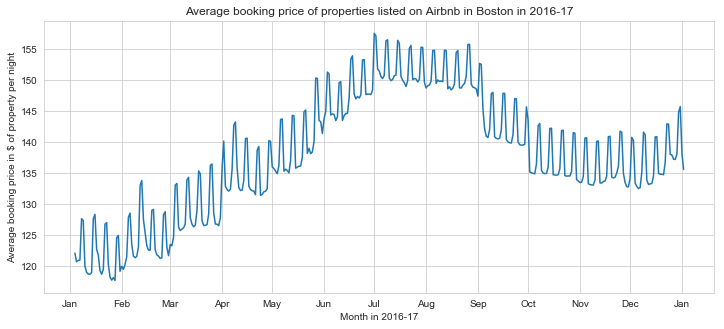

In [668]:
prices_2016_17 = avg_price_by_date[avg_price_by_date.index >= calendar_cleaned["date"].min()][avg_price_by_date.index <= calendar_cleaned["date"].max()]
dates = prices_2016_17.index
months = mdates.MonthLocator()
month_format = mdates.DateFormatter("%b")
fig, ax = plt.subplots()
fig.set_size_inches(12,5)
ax.plot(dates, prices_2016_17)
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(month_format)
yticks = ax.get_yticks()
# ax.set_yticklabels(['{}%'.format(y) for y in yticks])
ax.set_xlabel("Month in 2016-17")
ax.set_ylabel("Average booking price in $ of property per night")
ax.set_title("Average booking price of properties listed on Airbnb in Boston in 2016-17")
plt.show()
fig.savefig(project_dir + "/images/average_booking_price_boston_2016_2017.png")

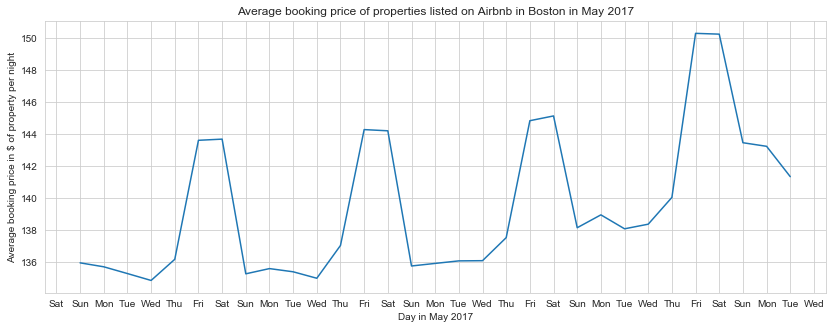

In [669]:
prices_in_summer = avg_price_by_date.loc[pd.date_range('2016-05-01', '2016-05-31')]
dates = prices_in_summer.index
days = mdates.DayLocator()
day_format = mdates.DateFormatter("%a")
fig, ax = plt.subplots()
fig.set_size_inches(14,5)
ax.plot(dates, prices_in_summer)
ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(day_format)
yticks = ax.get_yticks()
ax.set_xlabel("Day in May 2017")
ax.set_ylabel("Average booking price in $ of property per night")
ax.set_title("Average booking price of properties listed on Airbnb in Boston in May 2017")
plt.show()
fig.savefig(project_dir + "/images/average_booking_price_boston_may_2017.png")

In [677]:
cal_after_activation_dates["month"] = cal_after_activation_dates['date'].dt.month_name()

In [678]:
cal_after_activation_dates["year"] = cal_after_activation_dates['date'].dt.year.astype(str)

In [679]:
cal_after_activation_dates["day_of_week"] = cal_after_activation_dates['date'].dt.weekday_name

In [680]:
cal_after_activation_dates["week_of_month"] = np.ceil(cal_after_activation_dates['date'].dt.day/7).astype(int).astype(str)

In [681]:
cal_after_activation_dates["week_of_month"].unique()

array(['5', '1', '2', '3', '4'], dtype=object)

In [682]:
df = pd.merge(listings_cleaned, cal_after_activation_dates, left_on="id", right_on="listing_id", how="inner", suffixes=("_listings", "_calendar"))

In [683]:
# This one consumes too much memory and time, but it can give more accurate price estimates for fulling missing values
# g = df.groupby(["listing_id", "month", "day_of_week"]).apply(lambda x: x.sort_values(by=["date"]))
# g.loc[:, "price_calendar"] = g["price_calendar"].fillna(method="ffill")
# df = g.reset_index(drop=True)

In [684]:
g = df.groupby(["listing_id"]).apply(lambda x: x.sort_values(by=["date"]))

In [685]:
g.loc[:, "price_calendar"] = g["price_calendar"].fillna(method="ffill")

In [686]:
df = g.reset_index(drop=True)

In [687]:
df = df.dropna(subset=["available"])

### Adding Total Price and Availability of properties in the neighbourhood of given property on given day

In [688]:
env_vars = df.groupby(by=["latitude_category", "longitude_category", "date"]).agg({"price_calendar": ["mean", "std"], "available": "mean"})

In [689]:
env_vars.head(5)

price_calendar  \
                                                                              mean   
latitude_category          longitude_category            date                        
(47.5, 47.549899999999994] (-122.4, -122.35010000000001] 2016-01-04     110.577778   
                                                         2016-01-05     109.862745   
                                                         2016-01-06     109.711538   
                                                         2016-01-07     110.833333   
                                                         2016-01-08     114.241379   

                                                                                \
                                                                           std   
latitude_category          longitude_category            date                    
(47.5, 47.549899999999994] (-122.4, -122.35010000000001] 2016-01-04  88.826565   
                                                         2016-01-05  85.411245   
                                                         2016-01-06  84.541981   
                                                         2016-01-07  83.674064   
                                                         2016-01-08  86.928143   

                                                                    available  
                                                                         mean  
latitude_category          longitude_category            date                  
(47.5, 47.549899999999994] (-122.4, -122.35010000000001] 2016-01-04  1.000000  
                                                         2016-01-05  0.941176  
                                                         2016-01-06  0.884615  
                                                         2016-01-07  0.888889  
                                                         2016-01-08  0.862069

In [690]:
env_vars_copy = env_vars.copy()

In [691]:
env_vars_copy.columns = ["_env_".join(x) for x in env_vars_copy.columns.ravel()]

In [692]:
env_vars_copy.head(5)

price_calendar_env_mean  \
latitude_category          longitude_category            date                                  
(47.5, 47.549899999999994] (-122.4, -122.35010000000001] 2016-01-04               110.577778   
                                                         2016-01-05               109.862745   
                                                         2016-01-06               109.711538   
                                                         2016-01-07               110.833333   
                                                         2016-01-08               114.241379   

                                                                     price_calendar_env_std  \
latitude_category          longitude_category            date                                 
(47.5, 47.549899999999994] (-122.4, -122.35010000000001] 2016-01-04               88.826565   
                                                         2016-01-05               85.411245   
                                                         2016-01-06               84.541981   
                                                         2016-01-07               83.674064   
                                                         2016-01-08               86.928143   

                                                                     available_env_mean  
latitude_category          longitude_category            date                            
(47.5, 47.549899999999994] (-122.4, -122.35010000000001] 2016-01-04            1.000000  
                                                         2016-01-05            0.941176  
                                                         2016-01-06            0.884615  
                                                         2016-01-07            0.888889  
                                                         2016-01-08            0.862069

In [693]:
df = pd.merge(df, env_vars_copy, how="left", 
                           left_on=["latitude_category", "longitude_category", "date"],
                           right_on=["latitude_category", "longitude_category", "date"],
                          suffixes=("_property", "_env"))

In [694]:
df.head(5)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,date,available,price_calendar,month,year,day_of_week,week_of_month,price_calendar_env_mean,price_calendar_env_std,available_env_mean
0,3335,https://www.airbnb.com/rooms/3335,20160104002432,2016-01-04,Sweet Seattle Urban Homestead 2 Bdr,Welcome! If you stay here you will be living i...,Welcome! Come enjoy your time in Seattle at a...,Welcome! If you stay here you will be living i...,none,This is a very diverse neighborhood with a var...,...,2016-02-29,True,120.0,February,2016,Monday,5,87.056338,66.387152,0.971831
1,3335,https://www.airbnb.com/rooms/3335,20160104002432,2016-01-04,Sweet Seattle Urban Homestead 2 Bdr,Welcome! If you stay here you will be living i...,Welcome! Come enjoy your time in Seattle at a...,Welcome! If you stay here you will be living i...,none,This is a very diverse neighborhood with a var...,...,2016-03-01,True,120.0,March,2016,Tuesday,1,89.541667,76.178060,0.972222
2,3335,https://www.airbnb.com/rooms/3335,20160104002432,2016-01-04,Sweet Seattle Urban Homestead 2 Bdr,Welcome! If you stay here you will be living i...,Welcome! Come enjoy your time in Seattle at a...,Welcome! If you stay here you will be living i...,none,This is a very diverse neighborhood with a var...,...,2016-03-02,True,120.0,March,2016,Wednesday,1,89.583333,76.152691,0.972222
3,3335,https://www.airbnb.com/rooms/3335,20160104002432,2016-01-04,Sweet Seattle Urban Homestead 2 Bdr,Welcome! If you stay here you will be living i...,Welcome! Come enjoy your time in Seattle at a...,Welcome! If you stay here you will be living i...,none,This is a very diverse neighborhood with a var...,...,2016-03-03,True,120.0,March,2016,Thursday,1,90.319444,78.880160,0.972222
4,3335,https://www.airbnb.com/rooms/3335,20160104002432,2016-01-04,Sweet Seattle Urban Homestead 2 Bdr,Welcome! If you stay here you will be living i...,Welcome! Come enjoy your time in Seattle at a...,Welcome! If you stay here you will be living i...,none,This is a very diverse neighborhood with a var...,...,2016-03-04,True,120.0,March,2016,Friday,1,93.375000,80.812326,0.972222


In [700]:
df["price_calendar_normalized"] = (df["price_calendar"] - df["price_calendar_env_mean"]) / df["price_calendar_env_std"]

In [701]:
df["price_calendar_normalized"].head(5)

0    0.496236
1    0.399831
2    0.399417
3    0.376274
4    0.329467
Name: price_calendar_normalized, dtype: float64

### Adding historical booking probabilities given property in different scenarios defined by factors like
- mean and standard deviation of booking prices in the neighbourhood
- availability of props for booking in neighbourhood
- normalized price of property
- day of the week etc.

In [702]:
bin_size = df["price_calendar_normalized"].max()/50
bins = pd.IntervalIndex.from_tuples([(x, x+bin_size-0.0001) for x in float_range("0", str(df["price_calendar_normalized"].max()), str(bin_size))])
df["price_calendar_normalized_category"] = pd.cut(df["price_calendar_normalized"], bins)

In [703]:
bin_size = (df["price_calendar_env_mean"].max() - df["price_calendar_env_mean"].min())/20
bins = pd.IntervalIndex.from_tuples([(x, x+bin_size-0.0001) for x in float_range(str(df["price_calendar_env_mean"].min()), str(df["price_calendar_env_mean"].max()), str(bin_size))])
df["price_calendar_env_mean_category"] = pd.cut(df["price_calendar_env_mean"], bins)

In [704]:
bin_size = (df["price_calendar_env_std"].max() - df["price_calendar_env_std"].min())/20
bins = pd.IntervalIndex.from_tuples([(x, x+bin_size-0.0001) for x in float_range(str(df["price_calendar_env_std"].min()), str(df["price_calendar_env_std"].max()), str(bin_size))])
df["price_calendar_env_std_category"] = pd.cut(df["price_calendar_env_std"], bins)

In [705]:
bin_size = (df["available_env_mean"].max() - df["available_env_mean"].min())/20
bins = pd.IntervalIndex.from_tuples([(x, x+bin_size-0.0001) for x in float_range(str(df["available_env_mean"].min()), str(df["available_env_mean"].max()), str(bin_size))])
df["available_env_mean_category"] = pd.cut(df["available_env_mean"], bins)

In [706]:
gc.collect()
history = {}
df = df.sort_values(by=["listing_id","date"])
def add_booking_probability_in_similar_historical_scenario(row):
    scenario = {
        "listing_id": row["listing_id"],
        "price_calendar_normalized_category" : row["price_calendar_normalized_category"],
        "price_calendar_env_mean_category" : row["price_calendar_env_mean_category"],
        "price_calendar_env_std_category" : row["price_calendar_env_std_category"],
        "available_env_mean_category" : row["available_env_mean_category"],
        "day_of_week" : row["day_of_week"]
    }
    if str(scenario) in history:
        availability_in_similar_historical_scenario = history[str(scenario)]
        num_available = availability_in_similar_historical_scenario["available"]
        num_unavailable = availability_in_similar_historical_scenario["unavailable"]
        row["availability_prob_in_similar_historical_scenario"] = num_available/(num_available+num_unavailable)
        if row["available"]:
            availability_in_similar_historical_scenario["available"] += 1
        else:
            availability_in_similar_historical_scenario["unavailable"] += 1
    else:
        row["availability_prob_in_similar_historical_scenario"] = 0.5
        availability_in_similar_historical_scenario = {
            "available": 1 if row["available"] else 0,
            "unavailable": 0 if row["available"] else 1
        }
        history[str(scenario)] = availability_in_similar_historical_scenario
    return row

df = df.apply(add_booking_probability_in_similar_historical_scenario, axis=1)

Select a sample of properties to be used as an environment of alternatives competing with the property to be booked that can have impact on whether the given property gets booked or not.

In [577]:
# start_date = df["date"].min()

In [578]:
# listing_ids_environment = list(df.query("date == @start_date").drop_duplicates(['listing_id'])["listing_id"].sample(100, random_state=42))

In [579]:
# X_with_env = df[all_input_vars + ["listing_id", "date"]].query("listing_id not in @listing_ids_environment")
# for listing_id in listing_ids_environment:
#     listing_price_availability = df.query("listing_id == @listing_id")[["price_calendar", "available", "date"]]
#     X_with_env = pd.merge(X_with_env, listing_price_availability, left_on="date", right_on="date", how="inner", suffixes=("", "_"+str(listing_id)))

### Adding Normalized (Relative) Booking Prices for Properties

- Adding normalized prices for given property and all the properties used in the dataset serving as an indicator of competitive market condition. This will help ML models to easily learn conditions involving relative prices of the properties with much less complexity. 
- I am also retaining the absolute prices for properties in the environment and added one more field for storing total prices of all the properties in environment, so that the model can learn the current demand from the sample of prices from the overall market.

In [580]:
# price_columns_for_env = [col for col in X_with_env.columns if col.startswith("price_calendar") and col != "price_calendar"]
# price_columns_for_prop_and_env = [col for col in X_with_env.columns if col.startswith("price_calendar")]

In [581]:
# X_with_env.loc[:, "total_env_prices"] = X_with_env[price_columns_for_env].sum(axis=1)
# for price_column_for_prop_and_env in price_columns_for_prop_and_env:
#   X_with_env.loc[:, price_column_for_prop_and_env + "_normalized"] = X_with_env[price_column_for_prop_and_env] / X_with_env["total_env_prices"]

In [707]:
input_vars = ["neighbourhood_cleansed", 
#                 "neighbourhood_group_cleansed",
                "city",
                "state",
                "zipcode",
                "market",
                "location_categorical",
                "latitude_category",
                "longitude_category",
                "availability_prob_in_similar_historical_scenario",
                "price_calendar_normalized",
                "available_env_mean",
                "price_calendar_env_mean",
                "price_calendar_env_std",
                "property_type",
                "room_type",
                "accommodates",
                "bathrooms",
                "bedrooms",
                "beds",
                "bed_type",
                "square_feet",
                "guests_included",
                "minimum_nights",
                "maximum_nights",
                "review_scores_rating",
                "review_scores_accuracy",
                  "review_scores_cleanliness",
                  "review_scores_checkin",
                  "review_scores_communication",
                  "review_scores_location",
                  "review_scores_value",
#                   "jurisdiction_names",
                  "cancellation_policy",
#                   "reviews_per_month",
                  "number_of_reviews",
                            "month",
                            "year",
                            "day_of_week",
                            "week_of_month"
       ]
amenity_variables = list(map(lambda amenity : "amenity_" + amenity, possible_amenities))
input_vars.extend(amenity_variables)

In [543]:
# input_vars_from_calendar = ["year", "month", "day_of_week", "week_of_month", "price_calendar"]

In [544]:
# all_input_vars = input_vars_from_listings + input_vars_from_calendar;

In [582]:
# X_with_env = X_with_env_copy.drop(columns=["price_calendar"])

In [568]:
# X_with_env = df[input_vars + ["listing_id", "date"]]

In [583]:
# X_with_env = X_with_env.drop(columns=price_columns_for_env)

In [743]:
X = df.sort_values(by=["listing_id", "date"]).drop(columns=["date"]).reset_index(drop=True)[input_vars + ["listing_id"]]

In [585]:
# env_properties_availability_features = [col for col in X_with_env.columns if col.startswith("available")]

In [586]:
# X["fraction_of_properties_available"] = X[env_properties_availability_features].astype(int).sum(axis=1)/len(env_properties_availability_features)

In [587]:
# X["fraction_of_properties_available"].head()

In [744]:
y = df[["available","listing_id", "date"]].sort_values(by=["listing_id", "date"]).drop(columns=["date"]).reset_index(drop=True)

In [746]:
list(X.columns)

['neighbourhood_cleansed',
 'city',
 'state',
 'zipcode',
 'market',
 'location_categorical',
 'latitude_category',
 'longitude_category',
 'availability_prob_in_similar_historical_scenario',
 'price_calendar_normalized',
 'available_env_mean',
 'price_calendar_env_mean',
 'price_calendar_env_std',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'bed_type',
 'square_feet',
 'guests_included',
 'minimum_nights',
 'maximum_nights',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'cancellation_policy',
 'number_of_reviews',
 'month',
 'year',
 'day_of_week',
 'week_of_month',
 'amenity_TV',
 'amenity_Cable_TV',
 'amenity_Internet',
 'amenity_Wireless_Internet',
 'amenity_Air_Conditioning',
 'amenity_Kitchen',
 'amenity_Heating',
 'amenity_Family/Kid_Friendly',
 'amenity_Washer',
 'amenity_Dryer',
 'amenity_Fre

In [747]:
X.shape

(1226405, 79)

In [748]:
y.shape

(1226405, 2)

In [749]:
X.shape[0] == y.shape[0]

True

In [750]:
(X["listing_id"] == y["listing_id"]).all()

True

### Fill missing values in numeric columns with mean of the corresponding column

In [751]:
num_vars = X.select_dtypes(exclude=['object']).copy().columns
def fill_mean (col):
    return col.fillna(col.mean())
X.loc[X.index, num_vars] = X[num_vars].apply(fill_mean, axis=0)

### Convert categorical variables into numeric variables with separate column for missing values

In [752]:
cat_vars = X.select_dtypes(include=['object']).copy().columns
for var in  cat_vars:
    # for each cat add dummy var, drop original column
    X = pd.concat([X.drop(var, axis=1), pd.get_dummies(X[var], prefix=var, prefix_sep='_', drop_first=False, dummy_na=True)], axis=1)    

In [753]:
X.columns = [x.replace("[","_").replace("]", "_").replace(",","_").replace(" ","_").replace("<", "_") for x in X.columns]

### Splitting data into training and test sets while making sure that no property listing is common between them

In [754]:
unique_listing_ids = X["listing_id"].unique()

In [755]:
np.random.seed(42)
listing_ids_train = np.random.choice(np.array(unique_listing_ids), size= int(0.70 * len(unique_listing_ids)), replace=False)
listing_ids_test = [l for l in unique_listing_ids if l not in listing_ids_train]

In [756]:
X_train = X.query("listing_id in @listing_ids_train")
y_train = y.query("listing_id in @listing_ids_train")

In [757]:
(X_train.index == y_train.index).all()

True

I am using here only a smaller sample of training data to choose hyper parameters using cross validation technique to complete the experiments in timely manner. However, in real world scenario with availability of time, higher computational resources and memory, entire training dataset should be used for choosing optimal hyper parameters.

In [758]:
X_train_sample = X_train.sample(10000, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]

In [759]:
(X_train_sample["listing_id"] == y_train_sample["listing_id"]).all()

True

In [760]:
X_train_sample.shape

(10000, 517)

In [761]:
y_train_sample.shape

(10000, 2)

In [762]:
X_test = X.query("listing_id in @listing_ids_test").drop(columns=["listing_id"])
y_test = y.query("listing_id in @listing_ids_test").drop(columns=["listing_id"])

In [763]:
X_train_sample.to_csv(data_dir + "/X_train_sample.csv", index=False)
y_train_sample.to_csv(data_dir + "/y_train_sample.csv", index=False)

In [764]:
X_train.to_csv(data_dir + "/X_train.csv", index=False)
y_train.to_csv(data_dir + "/y_train.csv", index=False)

In [765]:
X_test.to_csv(data_dir + "/X_test.csv", index=False)
y_test.to_csv(data_dir + "/y_test.csv", index=False)

In [766]:
y_train["available"].value_counts()/y_train.shape[0]

True     0.763067
False    0.236933
Name: available, dtype: float64

Considering the ratio of samples classified for output True and False, the data looks to be slightly imbalanced. But as the ratio of 70:30 not too imbalanced like 90:10, we are choosing not to do any weighted sampling for them.

## Training Machine Learning Models

### Preparing cross validation splits to into training and test sets while making sure that no property listing is common between them

I haven't used `MyGridSearchCV` class anywhere in this notebook, 
as I decided to use Tree of Parzen Estimators Algorithm and Bayesian Optimization algo
implemented in Hyperopt and Scikit Optimize 
for quickly narrowing down the optimal hyper parameters

In [767]:
class MyGridSearchCV(object):
    
    def __init__(self, estimator, param_grid, cv=3):
        self.estimator = estimator
        self.param_grid = param_grid
        self.best_score = -math.inf
        self.best_estimator = None
        self.best_estimator_scores_mean = -math.inf
        self.best_estimator_scores_stdev = -math.inf
        self.best_params= None
        self.cv = cv       
    
    def fit(self, X, y):
        for param_point in self.get_param_grid_points():
            def splits(array, k):
                splits = []
                
                for i in range(k):
                    split_length = math.ceil(len(array)/k)
                    split = []
                    for j in range(i * split_length, (i+1) * split_length):
                        if j < len(array):
                            split.append(array[j])
                        
                    splits.append(split)
                cvs = []
                for i, split in enumerate(splits):
                    train = []
                    for j, other_split in enumerate(splits):
                        if i != j:
                            train += other_split
                    test = [] + split
                    cvs.append((train, test))
                return cvs
                    
            scores_for_point = []
            estimator = clone(self.estimator)
            estimator.set_params(**param_point)
            for l_train, l_test in splits(list(X["listing_id"].unique()), k=self.cv):                
                X_train = X.query("listing_id in @l_train").drop(columns=["listing_id"])
                X_test = X.query("listing_id in @l_test").drop(columns=["listing_id"])
                y_train = y.query("listing_id in @l_train").drop(columns=["listing_id"])
                y_test = y.query("listing_id in @l_test").drop(columns=["listing_id"])                
                estimator.fit(X_train, y_train.values.ravel())
                y_preds = estimator.predict(X_test)
                f1_score_1 = f1_score(y_test, y_preds, pos_label=True)
                f1_score_0 = f1_score(y_test, y_preds, pos_label=False)
                score = min([f1_score_1, f1_score_0])
                scores_for_point.append(score)
                gc.collect()
                
            mean_score = np.mean(scores_for_point)
            if mean_score > self.best_estimator_scores_mean:
                self.best_estimator_scores_mean = mean_score
                self.best_estimator_scores_stdev = np.std(scores_for_point)
                self.best_estimator = estimator
                self.best_params = self.best_estimator.get_params()
                self.best_score = self.best_estimator_scores_mean
            gc.collect()
            
    def get_param_grid_points(self):
        points = [{}]
        for param, values in self.param_grid.items():
            new_points = []
            for point in points:
                for value in values:                    
                    new_point = point.copy()
                    new_point[param]= value
                    new_points.append(new_point)
            points = new_points
        return points
    
    def print_best(self):
        print("Best score:")
        print(self.best_score)
        print("Best params:")
        print(self.best_params)
        print("Best estimator scores mean:")
        print(self.best_estimator_scores_mean)
        print("Best estimator scores stdev:")
        print(self.best_estimator_scores_stdev)

`my_cross_val_score` is used in calculating the score after each cross validation step
while tuning hyper parameters

In [768]:
def my_cross_val_score(estimator, X, y, fit_params=None, scoring="auc"):
    def splits(array, k):
        splits = []

        for i in range(k):
            split_length = math.ceil(len(array)/k)
            split = []
            for j in range(i * split_length, (i+1) * split_length):
                if j < len(array):
                    split.append(array[j])

            splits.append(split)
        cvs = []
        for i, split in enumerate(splits):
            train = []
            for j, other_split in enumerate(splits):
                if i != j:
                    train += other_split
            test = [] + split
            cvs.append((train, test))
        return cvs

    scores_for_point = []
    for l_train, l_test in splits(list(X["listing_id"].unique()), k=5):
        X_train = X.query("listing_id in @l_train").drop(columns=["listing_id"])
        y_train = y.query("listing_id in @l_train").drop(columns=["listing_id"])
        X_test = X.query("listing_id in @l_test").drop(columns=["listing_id"])
        y_test = y.query("listing_id in @l_test").drop(columns=["listing_id"])
        
        if fit_params is not None:
          estimator.fit(X=X_train, y=y_train.values.ravel(), **fit_params)
        else:
          estimator.fit(X=X_train, y=y_train.values.ravel())
        
        if scoring == "auc":
          y_preds_proba = estimator.predict_proba(X_test)
          score = roc_auc_score(y_test, y_preds_proba[:, 1])
        elif scoring == "logloss":        
          y_preds_proba = estimator.predict_proba(X_test)
          score = log_loss(y_test, y_preds_proba[:, 1])
        elif scoring == "f1":
          y_preds = estimator.predict(X_test)
          f1_score_1 = f1_score(y_test, y_preds, pos_label=True)
          f1_score_0 = f1_score(y_test, y_preds, pos_label=False)
          score = min([f1_score_1, f1_score_0])
          
        scores_for_point.append(score)
        gc.collect()

    mean_score = np.mean(scores_for_point)
    return mean_score



In [769]:
import decimal

def float_range(start, stop, step):
    start = decimal.Decimal(start)
    stop = decimal.Decimal(stop)
    step = decimal.Decimal(step)
    while (start < stop):
        yield float(start)
        start += step

In [0]:
X_train = pd.read_csv(data_dir + "/X_train.csv")
y_train = pd.read_csv(data_dir + "/y_train.csv")
garbage = gc.collect()

In [0]:
X_train_sample = pd.read_csv(data_dir + "/X_train_sample.csv")
y_train_sample = pd.read_csv(data_dir + "/y_train_sample.csv")
garbage = gc.collect()

In [770]:
validation_listing_ids = list(X_train_sample[["listing_id"]].drop_duplicates(["listing_id"]).sample(frac=0.1)["listing_id"])
X_val_es = X_train_sample.query("listing_id in @validation_listing_ids").drop(columns=["listing_id"])
y_val_es = y_train_sample.query("listing_id in @validation_listing_ids").drop(columns=["listing_id"])
X_train_es = X_train_sample.query("listing_id not in @validation_listing_ids")
y_train_es = y_train_sample.query("listing_id not in @validation_listing_ids")
garbage = gc.collect()

### Decision Tree Classifier for testing setup

I will be using **Tree of Parzen Estimators** algorithm implemented in **Hyperopt** library for choosing hyper parameters to be evaluated to find the optimal ones that maximizes the score = min(f1_score_for_positive_class, f1_score_for_negative_class)

In [ ]:
def objective_dtc(params):
    clf = DecisionTreeClassifier()
    clf.set_params(**params)    
    score = my_cross_val_score(clf, X=X_train_sample, y=y_train_sample, scoring="auc")
    print(params)
    print("auc roc: " + str(score))
    return score

dtc_param_space = {
    "min_samples_leaf": hp.choice("min_samples_leaf", [x/X_train_sample.shape[0] for x in range(1,6,2)]),
    "min_samples_split": hp.choice("min_samples_split", [2*x/X_train_sample.shape[0] for x in range(1,11,2)]),
    "max_depth": hp.choice("max_depth", [2**x for x in range(2,11)]),    
    "random_state": hp.choice("random_state", [42])
}
start_time = time.time()
best_params_dtc = space_eval(dtc_param_space, fmin(objective_dtc, dtc_param_space, algo=tpe.suggest, max_evals=50))
elapsed_time = (time.time() - start_time) / 60
print('Elapsed computation time: {:.3f} mins'.format(elapsed_time))
print ("Best params:")
print (best_params_dtc)


After having evaluated the approximate optimal value for max-depth hyper parameter to be around 16, I am using **Bayesian Optimization** technique implemented in `gp_minimize` method of **Scikit Optimize** package to choose precisely optimal hyper parameters that maximizes the score = min(f1_score_for_positive_class, f1_score_for_negative_class)

In [0]:
def objective_dtc(params):
    clf = DecisionTreeClassifier(
        max_depth = params[0],
        min_samples_leaf = params[1],
        min_samples_split = params[2],
        random_state = 42
    )
    score = my_cross_val_score(clf, X=X_train_sample, y=y_train_sample, scoring="auc")
    print ("Currently evaluating params:")
    print({
      "max_depth": params[0],
      "min_samples_leaf": params[1],
      "min_samples_split": params[2]
    })
    print ("auc roc: " + str(score))
    return score
start_time = time.time()
dtc_opt_result = gp_minimize(
    func=objective_dtc,
    dimensions=[
        (8, 30),
        (1, 10),
        (2, 20)
    ],
    random_state=42
)
elapsed_time = (time.time() - start_time) / 60
print('Elapsed computation time: {:.3f} mins'.format(elapsed_time))
best_params_list_dtc = dtc_opt_result.x
best_score_dtc = -dtc_opt_result.fun
best_params_dtc = {
    "max_depth": best_params_list_dtc[0],
    "min_samples_leaf": best_params_list_dtc[1],
    "min_samples_split": best_params_list_dtc[2]
}
print ("Best score (log loss): " + str(best_score_dtc))
print ("Best params: " + str(best_params_dtc))

In [ ]:
dtc = DecisionTreeClassifier()
dtc.set_params(**best_params_dtc)
dtc.fit(X=X_train.drop(columns=["listing_id"]), y=y_train.drop(columns=["listing_id"]))
pickle.dump(dtc, open(data_dir + '/dtc_best.pkl', 'wb'))

## Ensemble Learners

### Extreme Gradient Boosting (XGBoost)

Tuning hyper parameters using **Hyperopt**. I initially tried using Tree of Parzen Estimator's algorithm.

In [773]:
def f1_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    err = 1-f1_score(y_true, np.round(y_pred))
    return 'f1_err', err
evaluated_point_scores = {}
def objective_xgb(params):
    if (str(params) in evaluated_point_scores):
       return evaluated_point_scores[str(params)]
    else:      
      clf = XGBClassifier()
      clf.set_params(**params)    
      auc_roc = my_cross_val_score(clf, X=X_train_es, y=y_train_es, fit_params={
              "eval_set": [(X_val_es, y_val_es.values.ravel())],
              "early_stopping_rounds":20,
              "verbose": None,
              "eval_metric": "auc"
          }, scoring="auc")
      print(params)
      print("auc roc: " + str(auc_roc))
      evaluated_point_scores[str(params)] = -auc_roc
      return -auc_roc

xgb_param_space = {    
    "max_depth": hp.choice("max_depth", range(7,21,1)),    
#     "min_child_weight": hp.choice("min_child_weight", range(1,51,1)),    
#     "gamma": hp.choice("gamma", range(0, 11, 1)),
    "subsample": hp.choice("subsample", [0.7]),
    "random_state": hp.choice("random_state", [42]),
#     "tree_method": hp.choice("tree_method", ["gpu_hist"]),    
    "n_estimators": hp.choice("n_estimators", [1000])
}
start_time = time.time()
best_params_xgb = space_eval(
    xgb_param_space, 
    fmin(objective_xgb, 
         xgb_param_space, 
         algo=hyperopt.tpe.suggest,
         max_evals=30))
print(best_params_xgb)
elapsed_time = (time.time() - start_time) / 60
print('Elapsed computation time: {:.3f} mins'.format(elapsed_time))

{'max_depth': 8, 'n_estimators': 1000, 'random_state': 42, 'subsample': 0.7}
auc roc: 0.9252248845445891                         
{'max_depth': 12, 'n_estimators': 1000, 'random_state': 42, 'subsample': 0.7}  
auc roc: 0.9265397906330696                                                    
{'max_depth': 20, 'n_estimators': 1000, 'random_state': 42, 'subsample': 0.7}  
auc roc: 0.9248107124986629                                                    
{'max_depth': 18, 'n_estimators': 1000, 'random_state': 42, 'subsample': 0.7}  
auc roc: 0.9255348616113702                                                    
{'max_depth': 13, 'n_estimators': 1000, 'random_state': 42, 'subsample': 0.7}  
auc roc: 0.9251082498330211                                                    
{'max_depth': 14, 'n_estimators': 1000, 'random_state': 42, 'subsample': 0.7}  
auc roc: 0.9273491439435098                                                    
{'max_depth': 7, 'n_estimators': 1000, 'random_state': 42, 'subsample'

### Keeping our model realistic about the price elasticity for demand of properties

Note that for max_depth ranging from 7 to 20, we have have F1-score somewhere between 66 and 68. If our main target is to estimate the price elasticity for property on given day and market condition, then it is also important that our chosen model shows positive price elasticity for as many property listings as possible to be more realistic about how the world works based on economic principle of price elasticity for demand.

Note that this type of hyperparameter tuning is only supposed to be used if the number of properties showing positive price elasticity for demand are signficantly lower than expectations.

In [0]:
# def f1_eval(y_pred, dtrain):
#     y_true = dtrain.get_label()
#     err = 1-f1_score(y_true, np.round(y_pred))
#     return 'f1_err', err
# evaluated_point_scores = {}
# def objective_xgb(params):
#     if (str(params) in evaluated_point_scores):
#        return evaluated_point_scores[str(params)]
#     else:      
#       print(params)
#       clf = XGBClassifier()
#       clf.set_params(**params)
#       clf.fit(X=X_train_es.drop(columns=["listing_id"]), y=y_train_es.drop(columns=["listing_id"]).values.ravel(), 
#         eval_set=[(X_val_es, y_val_es.values.ravel())],
#         eval_metric= f1_eval,
#         early_stopping_rounds=50,
#         verbose=None
#        )
#       props_with_positive_elasticity = 0      
#       for index, listing in X_val_es.copy().sample(100, random_state=42).iterrows():
        
#         original_listing = listing.copy()
        
#         # Fitting a curve that captures to price elasticity trend
#         percentage = 20
#         n_points = 10
#         current_norm_price = listing["price_calendar_normalized"]
#         higher_price_normalized = current_norm_price * (1 + (percentage/100))
#         lower_price_normalized = max(0, current_norm_price * (1 - (percentage/100)))    
#         samples_price_norm = list(float_range(str(lower_price_normalized), str(higher_price_normalized), str((higher_price_normalized - lower_price_normalized)/n_points)))
#         samples_price_norm += list(float_range(str(current_norm_price * (0.95)), str(current_norm_price * (1.05)), str(current_norm_price * (0.1/(n_points/2)))))

#         probs = []
        
#         for sample_price_norm in samples_price_norm:
#           listing["price_calendar_normalized"] = sample_price_norm
#           df = pd.DataFrame(data=listing.to_dict(), index=[0])
#           prob = clf.predict_proba(df)[0][0]
#           probs.append(prob)  

#         X = pd.DataFrame({"x" : samples_price_norm})
#         y = pd.DataFrame({"y": probs})
#         curve = make_pipeline(PolynomialFeatures(degree=1), LinearRegression())
#         curve.fit(X,y)
        
#         # Calculating price elasticity 
#         percentage_to_check = 20
#         listing = original_listing.copy()
#         current_normalized_price = listing["price_calendar_normalized"]
#         norm_price_1 = min(0, current_normalized_price * (1 - percentage_to_check/100))
#         price_1 = norm_price_1 * listing["total_env_prices"]
#         listing["price_calendar_normalized"] = norm_price_1
#         df_norm_price_1 = pd.DataFrame(data={"x" : norm_price_1}, index=[0])
#         d_1 = curve.predict(df_norm_price_1)[0]

#         norm_price_2 = current_normalized_price * (1 + percentage_to_check/100)
#         price_2 = norm_price_2 * listing["total_env_prices"]
#         listing["price_calendar_normalized"] = norm_price_2
#         df_norm_price_2 = pd.DataFrame(data={"x" : norm_price_2}, index=[0])
#         d_2 = curve.predict(df_norm_price_2)[0]

#         price_change = (price_2 - price_1)/((price_2 + price_1)/2)
#         demand_change = (d_2 - d_1)/((d_2 + d_1)/2)
#         elasticity = - (demand_change / price_change)
#         if elasticity > 0:
#           props_with_positive_elasticity += 1
          
#       print("props_with_positive_elasticity: " + str(props_with_positive_elasticity))    
#       evaluated_point_scores[str(params)] = -props_with_positive_elasticity
#       return -props_with_positive_elasticity

# xgb_param_space = {    
#     "max_depth": hp.choice("max_depth", range(7,15,1)),    
# #     "min_child_weight": hp.choice("min_child_weight", range(1,51,1)),    
# #     "gamma": hp.choice("gamma", range(0, 11, 1)),
#     "subsample": hp.choice("subsample", [1.0]),
#     "random_state": hp.choice("random_state", [42]),
#     "tree_method": hp.choice("tree_method", ["gpu_hist"]),
#     "n_estimators": hp.choice("n_estimators", [1000])
# }
# start_time = time.time()
# best_params_xgb = space_eval(
#     xgb_param_space, 
#     fmin(objective_xgb, 
#          xgb_param_space, 
#          algo=hyperopt.tpe.suggest,
#          max_evals=20))
# print(best_params_xgb)
# elapsed_time = (time.time() - start_time) / 60
# print('Elapsed computation time: {:.3f} mins'.format(elapsed_time))

In [774]:
#Deciding optimal number of estimator trees
xgb = XGBClassifier()
xgb.set_params(**best_params_xgb)
xgb.fit(X=X_train_es.drop(columns=["listing_id"]), y=y_train_es.drop(columns=["listing_id"]).values.ravel(), 
        eval_set=[(X_val_es, y_val_es.values.ravel())],
        eval_metric= "auc",
        early_stopping_rounds=20,
        verbose=50
       )
best_params_xgb["n_estimators"] = xgb.best_ntree_limit
print ("Best params:")
print (best_params_xgb)

[0]	validation_0-auc:0.904699
Will train until validation_0-auc hasn't improved in 20 rounds.
Stopping. Best iteration:
[11]	validation_0-auc:0.920431

Best params:
{'max_depth': 14, 'n_estimators': 12, 'random_state': 42, 'subsample': 0.7}


In [775]:
# Training XGBoost using entire training dataset with optimal hyper parameters
# I am using small sample of 100,000 rows to train XGBoost as larger sample size
# containing million rows causes program to run out of memory
gc.collect()

X_train_sample_xgb = X_train.sample(100000, random_state=42)
y_train_sample_xgb = y_train.loc[X_train_sample_xgb.index]

xgb = XGBClassifier()
xgb.set_params(**best_params_xgb)
xgb.fit(X=X_train_sample_xgb.drop(columns=["listing_id"]), y=y_train_sample_xgb.drop(columns=["listing_id"]).values.ravel())

pickle.dump(xgb, open(data_dir + '/xgb_best.pkl', 'wb'))

### AdaBoost
The execution of even one iteration of of this algorithm appears to be very slow on this dataset. I have just kept this here for reference in case I want to try it in future.

In [0]:
def objective_ada(params):
    gc.collect()
    clf = AdaBoostClassifier(DecisionTreeClassifier())
    clf.set_params(**params)    
    score = my_cross_val_score(clf, X=X_train_sample, y=y_train_sample, scoring="f1")
    print(params)
    print("score: " + str(score))    
    return -score
ada_param_space = {
    "base_estimator__max_depth": hp.choice("base_estimator__max_depth", range(4,11,1)),
    "n_estimators": hp.choice("n_estimators", range(10, 101, 10)),
    "random_state": hp.choice("random_state", [42])
}
start_time = time.time()
best_params_ada = space_eval(ada_param_space, fmin(objective_ada, ada_param_space, algo=tpe.suggest, max_evals=25))
elapsed_time = (time.time() - start_time) / 60
print('Elapsed computation time: {:.3f} mins'.format(elapsed_time))
print ("Best params: ")
print (best_params_ada)
ada = AdaBoostClassifier(DecisionTreeClassifier())
ada.set_params(**best_params_ada)
ada.fit(X=X_train_sample.drop(columns=["listing_id"]), y=y_train_sample.drop(columns=["listing_id"]))
pickle.dump(ada, open(data_dir + '/ada_best.pkl', 'wb'))

## Support Vector Machine

The execution of even one iteration of of this algorithm appears to be very slow on this dataset. I have just kept this here for reference in case I want to try it in future.

In [0]:
def objective_svm(params):
    clf = SVC()
    clf.set_params(**params)
    score = my_cross_val_score(clf, X=X_train_sample, y=y_train_sample)
    print(params)
    print("score: " + str(score))
    return -score
svm_param_space = {
    "kernel": hp.choice("kernel", ['rbf']),
    "gamma": hp.choice("gamma", [0.001, 0.005, 0.01, 0.1, 1]),
    "C": hp.choice("C", [1, 5, 10, 50, 100, 500, 1000]),
    "random_state": hp.choice("random_state", [42]),
  
}
start_time = time.time()
best_params_svm = space_eval(svm_param_space, fmin(objective_svm, svm_param_space, algo=tpe.suggest, max_evals=50))
elapsed_time = (time.time() - start_time) / 60
print('Elapsed computation time: {:.3f} mins'.format(elapsed_time))
print ("Best params: ")
print (best_params_svm)
svm = SVC()
best_params_svm["probability"] = True
svm.set_params(**best_params_svm)
svm.fit(X=X_train.drop(columns=["listing_id"]), y=y_train.drop(columns=["listing_id"]).values.ravel())
pickle.dump(svm, open(data_dir + '/svm_best.pkl', 'wb'))

## Neural Network with Keras

For deciding number of hidden layers and number of neurons in each layer, I followed following rules of thumb suggested by some ML researches on discussion forums related to machine learning and statistics.
- The number of hidden neurons should be between the size of the input layer and the size of the output layer.
- The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer.
- The number of hidden neurons should be less than twice the size of the input layer.  

While these values can be a good starting point, the most optimal values for number and width of hidden layers can be decided by treating those numbers as hyperparameters to be tuned.

In [0]:
def make_model(n_features, n_hidden_layers, n_neurons_per_layer, reduction_in_num_of_neurons_per_layer, learn_rate):
    model = Sequential()    
    model.add(Dense(n_neurons_per_layer, input_shape=(n_features,), kernel_initializer='glorot_normal'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    for i in range(1, n_hidden_layers):
      model.add(Dense(int(n_neurons_per_layer * (1-reduction_in_num_of_neurons_per_layer)), kernel_initializer='glorot_normal'))
      model.add(Activation('relu'))
      model.add(BatchNormalization())
      model.add(Dropout(0.5))
    
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',
                optimizer=Adam(lr=learn_rate),
                metrics=['acc'])
    return model

### Hyper Parameter Tuner for Deep Learning model



In [0]:
class HyperTuner(object):
    
    def __init__(self, param_grid, cv=3):
        self.param_grid = param_grid
        self.best_score = -math.inf
        self.best_estimator_scores_median = -math.inf
        self.best_estimator_scores_mean = -math.inf
        self.best_estimator_scores_stdev = -math.inf
        self.best_params= None
        self.cv = cv       
    
    def fit(self, X, y):
        for param_point in self.get_param_grid_points():
            print ("Evaluating Parameter Values:")
            print (param_point)
            def splits(array, k):
                splits = []
                
                for i in range(k):
                    split_length = math.ceil(len(array)/k)
                    split = []
                    for j in range(i * split_length, (i+1) * split_length):
                        if j < len(array):
                            split.append(array[j])
                        
                    splits.append(split)
                cvs = []
                for i, split in enumerate(splits):
                    train = []
                    for j, other_split in enumerate(splits):
                        if i != j:
                            train += other_split
                    test = [] + split
                    cvs.append((train, test))
                return cvs
                    
            scores_for_point = []
            n_features = len(X.drop(columns=["listing_id"]).columns)
            n_hidden_layers = param_point["n_hidden_layers"]
            n_neurons_per_layer = param_point["n_neurons_per_layer"]
            reduction_in_num_of_neurons_per_layer = param_point["reduction_in_num_of_neurons_per_layer"]
            learn_rate = param_point["learn_rate"]

            for l_train, l_test in splits(list(X["listing_id"].unique()), k=self.cv):   
                model = make_model(n_features, n_hidden_layers, n_neurons_per_layer, reduction_in_num_of_neurons_per_layer, learn_rate)             
                X_train = X.query("listing_id in @l_train").drop(columns=["listing_id"])
                X_test = X.query("listing_id in @l_test").drop(columns=["listing_id"])
                y_train = y.query("listing_id in @l_train").drop(columns=["listing_id"])
                y_test = y.query("listing_id in @l_test").drop(columns=["listing_id"])                
                model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, verbose=0,
                callbacks=[
                  EarlyStopping(monitor='val_loss', verbose=0, patience=3),
                  ModelCheckpoint(data_dir + '/nn_best_model_temp.h5', monitor='val_loss', verbose=0)
                 ])
                model.load_weights(data_dir + "/nn_best_model_temp.h5")
                y_preds = model.predict_classes(X_test)
                f1_score_1 = f1_score(y_test, y_preds, pos_label=True)
                f1_score_0 = f1_score(y_test, y_preds, pos_label=False)
                score = min([f1_score_1, f1_score_0])
                scores_for_point.append(score)
                gc.collect()
                
            median_score = np.median(scores_for_point)
            
            print ("Done evaluation param point.\nScore: " + str(median_score))
            print ("-------------------------------------")
            if median_score > self.best_estimator_scores_median:
                self.best_estimator_scores_mean = np.mean(scores_for_point)
                self.best_estimator_scores_median = median_score
                self.best_estimator_scores_stdev = np.std(scores_for_point)
                self.best_params = param_point
                self.best_score = self.best_estimator_scores_median
            gc.collect()
            
        print ("Finished evaluating all values for hyper parameters.")
        print ("Best Parameter Values:")
        print (self.best_params)
        print ("Best Score (median of validation scores): " + str(median_score))
        gc.collect()
            
    def get_param_grid_points(self):
        points = [{}]
        for param, values in self.param_grid.items():
            new_points = []
            for point in points:
                for value in values:                    
                    new_point = point.copy()
                    new_point[param]= value
                    new_points.append(new_point)
            points = new_points
        return points
    
    def print_best(self):
        print("Best score (median of validation scores):")
        print(self.best_score)
        print("Best params:")
        print(self.best_params)
        print("Best estimator scores mean:")
        print(self.best_estimator_scores_mean)
        print("Best estimator scores stdev:")
        print(self.best_estimator_scores_stdev)

In [0]:
gc.collect()

In [0]:
# I have fixed hyper parameters to save time and memory consumption
# they can be tested by specifying values in the range as shown in comments

hyper_tuner = HyperTuner(param_grid={
    "n_hidden_layers": [3,5,7], # [3,4,5]
    "n_neurons_per_layer": [100, 500], # [50, 100, 150, 200]
    "reduction_in_num_of_neurons_per_layer": [0.2, 0.5], # [0, 0.1, 0.2, 0.5]
    "learn_rate": [0.01] # [0.001, 0.01, 0.1]
}, cv=3)
hyper_tuner.fit(X_train, y_train)

Evaluating Parameter Values:
{'n_hidden_layers': 3, 'n_neurons_per_layer': 100, 'reduction_in_num_of_neurons_per_layer': 0.2, 'learn_rate': 0.01}
Done evaluation param point.
Score: 0.1502380851154288
-------------------------------------
Evaluating Parameter Values:
{'n_hidden_layers': 5, 'n_neurons_per_layer': 100, 'reduction_in_num_of_neurons_per_layer': 0.2, 'learn_rate': 0.01}
Done evaluation param point.
Score: 0.5409145039033704
-------------------------------------
Evaluating Parameter Values:
{'n_hidden_layers': 7, 'n_neurons_per_layer': 100, 'reduction_in_num_of_neurons_per_layer': 0.2, 'learn_rate': 0.01}
Done evaluation param point.
Score: 0.46514626249892554
-------------------------------------
Finished evaluating all values for hyper parameters.
Best Parameter Values:
{'n_hidden_layers': 5, 'n_neurons_per_layer': 100, 'reduction_in_num_of_neurons_per_layer': 0.2, 'learn_rate': 0.01}
Best Score (median of validation scores): 0.46514626249892554


In [0]:
hyper_tuner.print_best()

Best score (median of validation scores):
0.5409145039033704
Best params:
{'n_hidden_layers': 5, 'n_neurons_per_layer': 100, 'reduction_in_num_of_neurons_per_layer': 0.2, 'learn_rate': 0.01}
Best estimator scores mean:
0.39701294453662844
Best estimator scores stdev:
0.21361699787078586


Preparing the best model with optimal values of hyper parameters.

- I have used Early stopping to prevent the neural network overfit to the training data while being trained on same data through multiple epochs.  
- I have also used ModelCheckpoint that saves the weights of last best performing model, so that I can set early stopping patience to greater zero and it allows a few epochs to be executed to confirm that the performance of model on unseen data is unlikely to improve by running any more epochs.

In [0]:
n_features = len(X_train.drop(columns=["listing_id"]).columns)
n_hidden_layers = hyper_tuner.best_params["n_hidden_layers"]
n_neurons_per_layer = hyper_tuner.best_params["n_neurons_per_layer"]
reduction_in_num_of_neurons_per_layer = hyper_tuner.best_params["reduction_in_num_of_neurons_per_layer"]
learn_rate = hyper_tuner.best_params["learn_rate"]
nn_model = make_model(n_features, n_hidden_layers, n_neurons_per_layer, reduction_in_num_of_neurons_per_layer, learn_rate)
validation_listing_ids = list(X_train[["listing_id"]].drop_duplicates(["listing_id"]).sample(frac=0.1)["listing_id"])
X_val_nn = X_train.query("listing_id in @validation_listing_ids").drop(columns=["listing_id"])
y_val_nn = y_train.query("listing_id in @validation_listing_ids").drop(columns=["listing_id"])
X_train_nn = X_train.query("listing_id not in @validation_listing_ids").drop(columns=["listing_id"])
y_train_nn = y_train.query("listing_id not in @validation_listing_ids").drop(columns=["listing_id"])       
nn_model.fit(X_train_nn, y_train_nn, validation_data=(X_val_nn, y_val_nn), epochs=50, verbose=1,
        callbacks=[
          EarlyStopping(monitor='val_loss', verbose=1, patience=5),
          ModelCheckpoint(data_dir + '/nn_best_model_cv.h5', monitor='val_loss', verbose=1)
        ])





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 801540 samples, validate on 89060 samples
Epoch 1/50
801540/801540 [==============================] - 629s 785us/step - loss: 0.6457 - acc: 0.6305 - val_loss: 0.7321 - val_acc: 0.5566

Epoch 00001: saving model to /content/gdrive/My Drive/Data Scientist/airbnb/data/boston/nn_best_model_cv.h5
Epoch 2/50
801540/801540 [==============================] - 636s 794us/step - loss: 0.6064 - acc: 0.6729 - val_loss: 1.3314 - val_acc: 0.5189

Epoch 00002: saving model to /content/gdrive/My Drive/Data Scientist/airbnb/data/boston/nn_best_model_cv.h5
Epoch 3/50
801540/801540 [==============================] - 635s 793us/step - loss: 0.5941 - acc: 0.6809 - val_loss: 0.6687 - val_acc: 0.5769

Epoch 00003: saving model to /content/gdrive/My Drive/Data Scientist/airbnb/data/boston/n

In [0]:
nn_model.load_weights(data_dir + '/nn_best_model_cv.h5')

NameError: ignored

## Prediction & Model Evaluation

In [0]:
X_test = pd.read_csv(data_dir + "/X_test.csv")
y_test = pd.read_csv(data_dir + "/y_test.csv")
garbage = gc.collect()

### Evaluating Neural Network

In [0]:
nn_model = load_model(data_dir + "/nn_best_model_cv.h5")





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
nn_model.evaluate(x=X_test,y=y_test)

381790/381790 [==============================] - 44s 115us/step


[1.7062076889896705, 0.4929909112339244]

In [0]:
nn_model.metrics_names

['loss', 'acc']

In [0]:
y_preds_nn = nn_model.predict_classes(X_test)

In [0]:
f1 = f1_score(y_test, y_preds_nn, average="macro")
print ("f1-score: " + str(f1))

f1-score: 0.3332499128322169


In [0]:
nn_model.predict(X_test.iloc[0:5, :])

array([[0.69107455],
       [0.8719443 ],
       [0.84361106],
       [0.9132275 ],
       [0.888119  ]], dtype=float32)

### Evaluating Learners

In [777]:
models = {
    "Extreme Gradient Boost": data_dir + "/xgb_best.pkl",
#     "Single Decision Tree": data_dir + "/dtc_best.pkl",
    #     "Gradient Boost": data_dir + "/gb_best.pkl",
    #     "Ada Boost": data_dir + "/ada_best.pkl",
    #     "SVM": data_dir + "/svm_best.pkl",
}

In [778]:
for model_name in models.keys():
    model_file_name = models[model_name]
    model = pickle.load(open(model_file_name, 'rb'))
    y_preds = model.predict(X_test)
    y_preds_proba = model.predict_proba(X_test)
    f1 = f1_score(y_test, y_preds, average="macro")
    logloss = log_loss(y_test, y_preds_proba[:,1])
    auc = roc_auc_score(y_test, y_preds_proba[:, 1])
    print ("Model: " + model_name + "\nParams: " + str(model.get_params()) + "\nf1-score: " + str(f1) + " log loss: " + str(logloss) + "\n roc auc: " + str(auc))
    gc.collect()

Model: Extreme Gradient Boost
Params: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': nan, 'n_estimators': 12, 'n_jobs': 1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 0.7, 'verbosity': 1}
f1-score: 0.8545987146257177 log loss: 0.3238436402632052
 roc auc: 0.9348091011294977


## Model Interpretation

In [ ]:
import pprint
pp = pprint.PrettyPrinter(indent=4)
def print_top10(feature_names, clf, class_labels):
    """Prints features with the highest coefficient values, per class"""
    pp.pprint(sorted(list(zip(feature_names, clf.feature_importances_)), key=lambda x: x[1], 
reverse=True)[:20])

for model_name in models.keys():
    model_file_name = models[model_name]
    model = pickle.load(open(model_file_name, 'rb'))
    print("\nModel: " + model_name)
    print("Best Params: ")
    pp.pprint(model.get_params())
    print("Top 10 Feature importances: ")
    print_top10(X_train_sample.columns, model, model.classes_)

## Tuning the booking price of property

### Aim: Maximizing expected revneue from individual properties

Here I tune the booking price of the property by looking at the probability of the property being booked at given price. If the probability is too low, I try increasing it by setting the price the of that property slightly low and see if it increases the probability. My goal is to maximize the profit of the company by maximizing expected revneue from individual properties. 

As per the economic principle of price elasticity of demand, the quantity of a product demanded should be varying with changes in price like this curve if the demanded quantity is elastic to the price.

![Price Elasticity of Demand Curve](http://wikieducator.org/images/0/0f/Ed1.jpeg)

In our case, the quantity of demand synonymous to the probability of the property being booked and the price is the booking price of the property. Let's try and check if some randomly selected properties from our dataset demonstrates price elasticity for probability of being booked.

In [776]:
import decimal

def float_range(start, stop, step):
    start = decimal.Decimal(start)
    stop = decimal.Decimal(stop)
    step = decimal.Decimal(step)
    while (start < stop):
        yield float(start)
        start += step

### Methods to calculate probability of a property being booked at given normalized price and market condition


In [0]:
nn_model = load_model(data_dir + "/nn_best_model_cv.h5")
def calc_prob_booked_nn(row):
  df = pd.DataFrame(data=row.to_dict(), index=[0])
  return 1 - nn_model.predict(df)[0][0]





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
xgb_clf = pickle.load(open(data_dir + "/xgb_best.pkl", 'rb'))
def calc_prob_booked_xgb(row):
  df = pd.DataFrame(data=row.to_dict(), index=[0])  
  return xgb_clf.predict_proba(df)[0][0]

In [ ]:
dtc_clf = pickle.load(open(data_dir + "/dtc_best.pkl", 'rb'))
def calc_prob_booked_dtc(row):
  df = pd.DataFrame(data=row.to_dict(), index=[0])  
  return dtc_clf.predict_proba(df)[0][0]

In [0]:
# gb_clf = pickle.load(open(data_dir + "/gb_best.pkl", 'rb'))
# def calc_prob_booked_gb(row):
#   df = pd.DataFrame(data=row.to_dict(), index=[0])
#   return gb_clf.predict_proba(df)[0][0]

In [0]:
# ada_clf = pickle.load(open(data_dir + "/ada_best.pkl", 'rb'))
# def calc_prob_booked_ada(row):
#   df = pd.DataFrame(data=row.to_dict(), index=[0])
#   return ada_clf.predict_proba(df)[0][0]

### Price Elasticity for probability of a property getting booked

In [219]:
def draw_price_elasticity_curves(calc_prob_booked):
  fig, ax = plt.subplots(3, 2, figsize=(15,10))
  sample_listings = [listing for (index, listing) in X_test.sample(6, random_state=42).copy().iterrows()]
  percentage_to_check = 20
  for plot_row in range(0,3):
    for plot_col in range(0,2):  
      listing = sample_listings.pop()
      current_normalized_price = listing["price_calendar_normalized"]
      current_price = int(round(listing["price_calendar_normalized"] * listing["total_env_prices"],0))
      price_upper = current_normalized_price * (1 + percentage_to_check/100)
      price_lower = current_normalized_price * (1 - percentage_to_check/100)
      normalized_price_range = list(float_range(str(price_lower), str(price_upper), str((price_upper - price_lower)/50)))

      probs = []
      absolute_prices = [listing["total_env_prices"] * normalized_price for normalized_price in normalized_price_range]

      for price in normalized_price_range:
          listing["price_calendar_normalized"] = price
          prob = calc_prob_booked(listing)
          probs.append(prob)

      price_elasticity_curve, = ax[plot_row, plot_col].plot(absolute_prices, probs)
      ax[plot_row, plot_col].set_ylabel('Probability of property being booked')
      ax[plot_row, plot_col].set_xlabel('Booking price of property')
      current_price_line = ax[plot_row, plot_col].axvline(x=current_price, color='g')   


      ax[plot_row, plot_col].legend((current_price_line, ), ('Current price = ' +str(current_price), ))

  plt.show()

### Price elasticity for probability of booking learnt by Neural Network

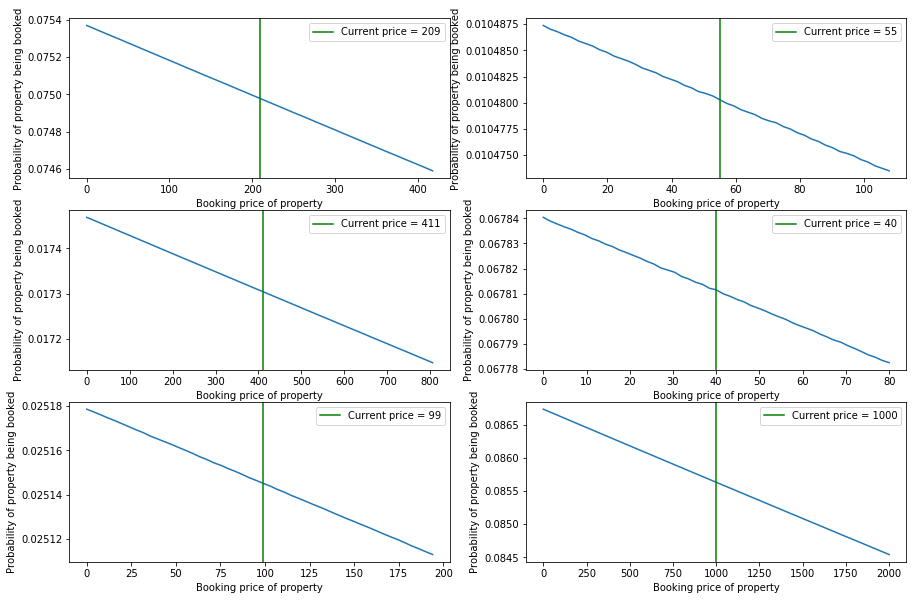

In [0]:
draw_price_elasticity_curves(calc_prob_booked_nn)

As we can see above, choosing some random properties from dataset and plotting relationship between normalized price and probability of getting the property booked shows that they demonstrate price elasticity for probability of the property being booked.

Although the price elasticity curve generated using Neural Network is smooth, it represents that probability of property getting booked is inelastic towards price in very large price range. Such model does not very well represent the real world scenario where demand of property can be inelastic to price within only a small range of price.

In my first iteration of project, I tried using absolute price to evaluate the relationship between probability of property being booked and the price. At that time, I the plot did not follow the price elasticity curve.

One of the assumption in the price elasticity curve is that all the other factors in the market should be held relatively constant and only the price of the property should be varying. Only then the relation between booking probability and price will follow the popular price elasticity curve in wide range of price variation.

The absolute value of price may have been increased in the dataset when the overall demand of properties for booking have increased. In such case, the property might be still getting booked at higher price duing the periods of higher demand. Therefore based on the dataset, the model trained on absolute price will suggest that the probability of booking may also increase when the property price is increased. 

To tackle this issue, I implemented workaround by normalizing the price relative to the sum of booking prices of all the other 100 properties that we are using in our training dataset to represent the competitive market environment conditions. Now we can observe the trend of change in probability along with the change in relative price and see that it shows some price elasticity as expected.

### Price Elasticity for probability of booking learnt by Extreme Gradient Boosting (XGBoost)

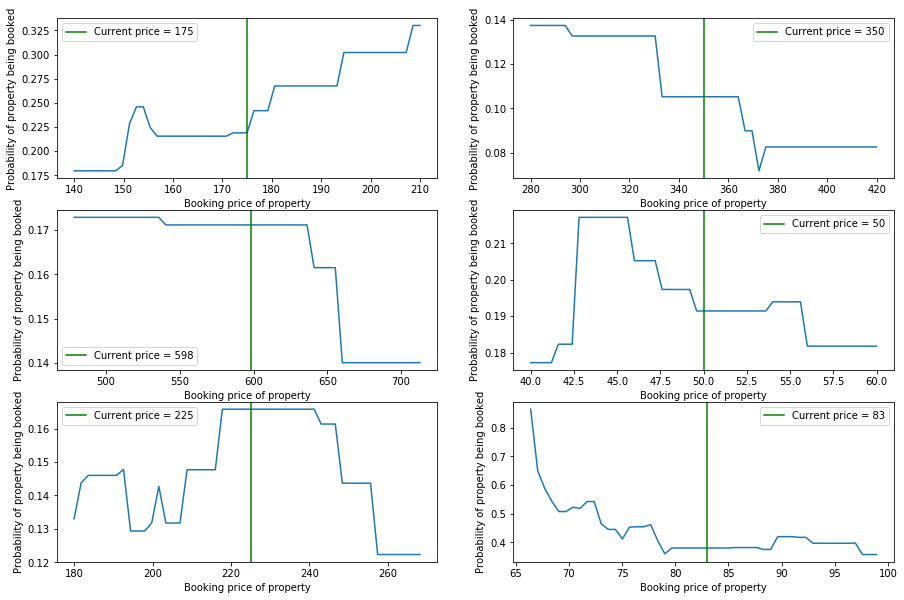

In [220]:
draw_price_elasticity_curves(calc_prob_booked_xgb)

As you can see in this sample, 4 out of 6 images are showing trend of positive price elasticity where as the booking price of property under given market condition increases, the probability of being booked decreases.

### Price Elasticity for probability of booking learnt by Gradient Boosting

In [0]:
# draw_price_elasticity_curves(calc_prob_booked_gb)

### Price Elasticity for probability of booking learnt by Ada Boost

In [0]:
# draw_price_elasticity_curves(calc_prob_booked_ada)

### Price elasticity for probability of booking learnt by Single Decision Tree

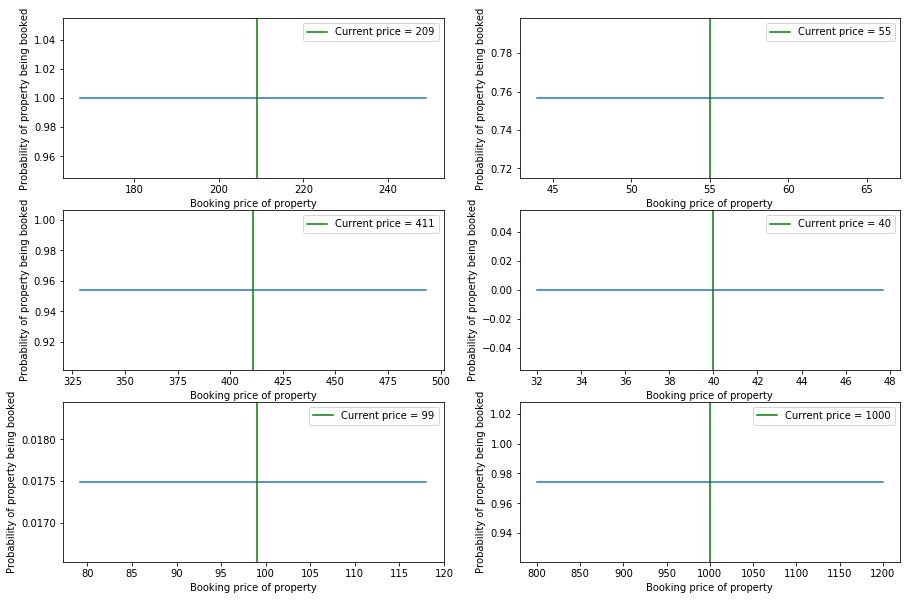

In [57]:
draw_price_elasticity_curves(calc_prob_booked_dtc)

### Calculating the expected revenue from properties after tuning the price

Let's tune prices of the properties that show significant price elasticity for demand.

`get_price_elasticity_curve` function gets price elasticity curve for the probability of property getting booked by calculating the probability from the given calc_prob_booked function within a range values varying from current normalized price of property by specified percentage. It then fits a polynomial curve that fits the points calculated from the probability of property getting booked at that normalized price point it returns that fitted curve as output.

In [221]:
def get_price_elasticity_curve(listing, calc_prob_booked, percentage, n_points=100):
  current_norm_price = listing["price_calendar_normalized"]
  higher_price_normalized = current_norm_price * (1 + (percentage/100))
  lower_price_normalized = max(0, current_norm_price * (1 - (percentage/100)))    
  samples_price_norm = list(float_range(str(lower_price_normalized), str(higher_price_normalized), str((higher_price_normalized - lower_price_normalized)/n_points)))
  samples_price_norm += list(float_range(str(current_norm_price * (0.95)), str(current_norm_price * (1.05)), str(current_norm_price * (0.1/(n_points/2)))))

  probs = []
  
  for sample_price_norm in samples_price_norm:
    listing["price_calendar_normalized"] = sample_price_norm
    prob = calc_prob_booked(listing)
    probs.append(prob)  

  X = pd.DataFrame({"x" : samples_price_norm})
  y = pd.DataFrame({"y": probs})
  curve = make_pipeline(PolynomialFeatures(degree=1), LinearRegression())
  curve.fit(X,y)
  return curve

In [222]:
def draw_price_elasticity_for_prop(listing, calc_prob_booked, percentage, curve, rec_price):
    square_feet = listing["square_feet"]
    beds = listing["beds"]
    bedrooms = listing["bedrooms"]
    accommodates = listing["accommodates"]
  
    print (f"Price elasticity plot for a property of")
    print (f"Size: {square_feet}sq.ft")
    print (f"Accommodates: {accommodates}")
    print (f"Bedrooms: {bedrooms}")
    current_normalized_price = listing["price_calendar_normalized"]
    mu = listing["price_calendar_env_mean"]
    sigma = listing["price_calendar_env_std"]
    z = current_normalized_price
    current_price = int(round((z * sigma) + mu, 0))
    price_upper = current_normalized_price * (1 + percentage/100)
    price_lower = current_normalized_price * max(0, (1 - percentage/100))
    normalized_price_range = list(float_range(str(price_lower), str(price_upper), str((price_upper - price_lower)/50)))

    probs = []
    absolute_prices = [(normalized_price * sigma) + mu for normalized_price in normalized_price_range]
    curve_probs = []
    for price in normalized_price_range:
        listing["price_calendar_normalized"] = price
        prob = calc_prob_booked(listing)
        probs.append(prob)       
        df_norm_price = pd.DataFrame(data={"x" : price}, index=[0])
        curve_prob = curve.predict(df_norm_price)[0]
        curve_probs.append(curve_prob)
   
    price_elasticity_curve, = plt.plot(absolute_prices, probs)
    regression_curve, = plt.plot(absolute_prices, curve_probs)
    recommended_price_line = plt.axvline(x=rec_price, color='g')
    plt.ylabel('Probability of property being booked')
    plt.xlabel('Booking price of property')
    beds = listing["beds"]
    square_feet= listing["square_feet"]
    current_price_line = plt.axvline(x=current_price, color='r')   
    plt.legend((current_price_line, 
                recommended_price_line,
                price_elasticity_curve, 
                regression_curve), 
               ('Current price = ' +str(current_price), 
                'Recommended price = ' + str(rec_price),
                'Booking probability at price', 
                'Fitted Regression line'))
    plt.show()

- For each property I first check whether the property follows conventional price elasticity where the probability of the property getting booked increases as its relative price is decreased and only tuned price for those properties that demonstrated such trend.
- Instead of using exact probability predicted by the classifier, I decided to use the one derived from line fitted on the predicted probability values for normalized price range near the current normalized price, so that tuning algorithm has to work with smoothly varying values that smoothes sudden bumps in the probability values often seen to be generated by ensemble learners.

In [243]:
def calculate_price_elasticity(curve, listing, percentage_to_check):
    mu = listing["price_calendar_env_mean"]
    sigma = listing["price_calendar_env_std"]
  current_normalized_price = listing["price_calendar_normalized"]
  norm_price_1 = max(0, current_normalized_price * (1 - percentage_to_check/100))
  price_1 = norm_price_1 * sigma + mu
  listing["price_calendar_normalized"] = norm_price_1
  df_norm_price_1 = pd.DataFrame(data={"x" : norm_price_1}, index=[0])
  d_1 = curve.predict(df_norm_price_1)[0]

  norm_price_2 = current_normalized_price * (1 + percentage_to_check/100)
  price_2 = norm_price_2 * sigma + mu
  listing["price_calendar_normalized"] = norm_price_2
  df_norm_price_2 = pd.DataFrame(data={"x" : norm_price_2}, index=[0])
  d_2 = curve.predict(df_norm_price_2)[0]

  price_change = (price_2 - price_1)/((price_2 + price_1)/2)
  demand_change = (d_2 - d_1)/((d_2 + d_1)/2)
  elasticity = - (demand_change / price_change)
  return elasticity

I decided to tune the prices of properties using Extreme Gradient Boosting model for predicting probability of property being booked under giving time, price and market conditions. The reason is that it shows higher prediction accuracy as compared to neural network model. Even though the predicted probability graph while varying normalized price is not as smooth as the one generated by neural network, the more accurate prediction of probabilities for property getting booked leads to more accurate prediction for expected revenue from properties at given price point.

In [245]:
def extract_price_elasticity_info(row):
  percentage_for_calculating_elasticity = 20
  row_1 = row.copy()
  curve = get_price_elasticity_curve(listing=row_1, calc_prob_booked=calc_prob_booked_xgb, percentage=percentage_for_calculating_elasticity, n_points=10)
  elasticity = calculate_price_elasticity(curve, listing=row_1, percentage_to_check=percentage_for_calculating_elasticity)
  
  current_price_norm = row_1["price_calendar_normalized"]  
  df_current = pd.DataFrame(data={"x" : current_price_norm}, index=[0])  
  prob_current_price = curve.predict(df_current)[0]   
  current_expected_revenue = prob_current_price * current_price_norm * row_1["total_env_prices"]

  max_expected_revenue = -math.inf
  prob_at_max = None
  price_at_max = None
  norm_price_at_max = None

  lower_price_normalized = max(current_price_norm * (1 - percentage_for_calculating_elasticity/100), 0)
  higher_price_normalized = current_price_norm * (1 + percentage_for_calculating_elasticity/100)
  for trial_price_norm in float_range(str(lower_price_normalized), str(higher_price_normalized), str((higher_price_normalized-lower_price_normalized)/100)):
    # Instead of using probability predicted by the classifier,
    # I decided to use the one derived from line fitted on the values
    # in normalized price range near the current normalized price
    # so that I can have a smoothly varying values which avoid sudden
    # bumps in the probability values often seen to be generated by
    # ensemble learners.
#             row_1["price_calendar_normalized"] = trial_price_norm
#             prob_at_trial_price_norm = calc_prob_booked_xgb(row)
      df_trial = pd.DataFrame(data={"x" : trial_price_norm}, index=[0])
      prob_at_trial_price_norm = curve.predict(df_trial)[0]   
      expected_revenue = prob_at_trial_price_norm * trial_price_norm * row["total_env_prices"]
      if expected_revenue > max_expected_revenue:
          max_expected_revenue = expected_revenue
          prob_at_max = prob_at_trial_price_norm
          price_at_max = trial_price_norm * row["total_env_prices"]
          norm_price_at_max = trial_price_norm
  row_1["price_elasticity"] = np.asscalar(elasticity)
  row_1["current_price"] = current_price_norm * row_1["total_env_prices"]
  row_1["expected_revenue_current_price"] = np.asscalar(current_expected_revenue)
  row_1["recommended_price"] = price_at_max
  row_1["recommended_normalized_price"] = norm_price_at_max
  row_1["expected_revenue_recommended_price"] = np.asscalar(max_expected_revenue)
  
  row_1["booking_probability_at_current_price"] = prob_current_price
  row_1["booking_probability_at_recommended_price"] = prob_at_max
  return row_1

In [246]:
X_test.sample(10, random_state=42).apply(extract_price_elasticity_info, axis=1)[["price_elasticity",
                                                                                 "current_price",
                                                                                 "expected_revenue_current_price",
                                                                                 "recommended_price",
                                                                                "expected_revenue_recommended_price"                                                                                 
                                                                                ]].head(10)

,price_elasticity,current_price,expected_revenue_current_price,recommended_price,expected_revenue_recommended_price
1153073,2.237118,104.58,22.015534,83.66400,34.725464
841535,-0.231293,278.10,44.254849,332.60760,55.680833
744524,0.112923,63.00,11.773891,75.60000,13.736914
825565,0.512893,753.48,109.578941,901.16208,113.439648
511286,1.666974,432.60,29.296689,346.08000,37.503647
291252,-1.465492,220.50,74.878217,263.71800,113.425643
1298130,3.450276,238.14,7.863883,190.51200,23.098783
145938,2.482612,115.92,4.841318,92.73600,8.456517
484550,-0.093458,79.38,19.236923,94.93848,23.503814
892335,-2.910428,163.80,26.840453,195.90480,45.990637


In [300]:
tuned_data = X_test.sample(10000, random_state=42).copy().apply(extract_price_elasticity_info, axis=1)

In [301]:
tuned_data.to_csv(data_dir + "/tuned_data_20.csv", index=False)

## Analysing dataset containing tuned prices for properties
I just created a dataframe containing data about recommended prices and changes in expected revenue after tuning prices of 1000 properties from our test dataset within 20% of their current price.

Let's checkout the distribution of price elasticity values.

Text(0.5, 1.0, 'Distribution of properties for price elasticity of demand')

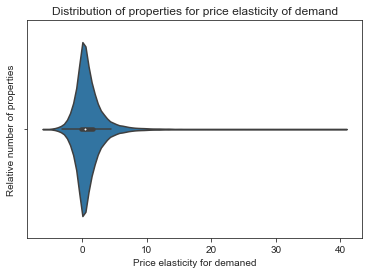

In [302]:
violin = sns.violinplot(x=tuned_data["price_elasticity"])
violin.set_xlabel("Price elasticity for demaned")
violin.set_ylabel("Relative number of properties")
violin.set_title("Distribution of properties for price elasticity of demand")

Text(0.5, 1.0, 'Distribution zoomed in between elasticity from -2 to 2')

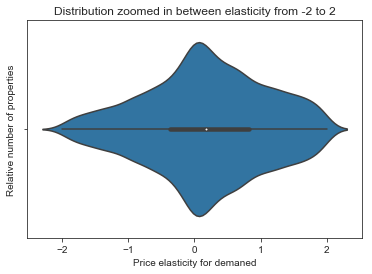

In [341]:
violin = sns.violinplot(x=tuned_data.query("price_elasticity < 2 and price_elasticity > -2")["price_elasticity"])
violin.set_xlabel("Price elasticity for demaned")
violin.set_ylabel("Relative number of properties")
violin.set_title("Distribution zoomed in between elasticity from -2 to 2")

Taking look at proportion of number of properties with positive price elasticity vs negative price elasticity.

In [304]:
100 * (tuned_data["price_elasticity"] > 0).value_counts()/(tuned_data["price_elasticity"]).count()

True     65.74
False    34.26
Name: price_elasticity, dtype: float64

One good thing about our trained XGBoost based prediction model is that there are more number of samples demonstrating positive price elasticity than the ones showing negative price elasticity.

In [305]:
tuned_data["price_elasticity"].quantile([.25, .5, .75])

0.25   -0.291243
0.50    0.425109
0.75    1.615132
Name: price_elasticity, dtype: float64

### How does the average price elasticity of demand varies with the average price of properties?

Let's first check the current price distribution of booking properties in our sample of 1000 properties.


Text(0.5, 1.0, 'Distribution of properties for average price')

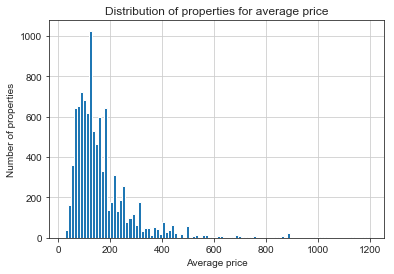

In [306]:
prices_hist = tuned_data["current_price"].hist(bins=100)
prices_hist.set_xlabel("Average price")
prices_hist.set_ylabel("Number of properties")
prices_hist.set_title("Distribution of properties for average price")

Text(0.5, 1.0, 'Distribution of properties for average price')

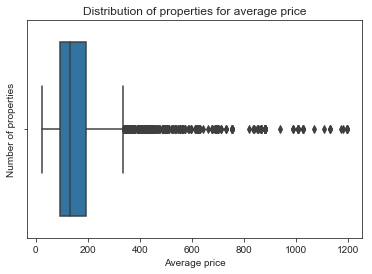

In [307]:
prices_violin = sns.boxplot(x=tuned_data["current_price"])
prices_violin.set_xlabel("Average price")
prices_violin.set_ylabel("Number of properties")
prices_violin.set_title("Distribution of properties for average price")

As we can see prices for most of the property listings in this sample are between 0 to 650.

In [308]:
np.std(tuned_data["current_price"])

124.38814355733241

In [309]:
bin_size = 50 
bins = pd.IntervalIndex.from_tuples([(x, x+bin_size-1) for x in range(1,tuned_data["current_price"].astype(int).max(),bin_size)])
pd.cut(tuned_data["current_price"], bins)
tuned_data_1 = tuned_data.copy()
tuned_data_1["current_price_category"] = pd.cut(tuned_data["current_price"], bins)

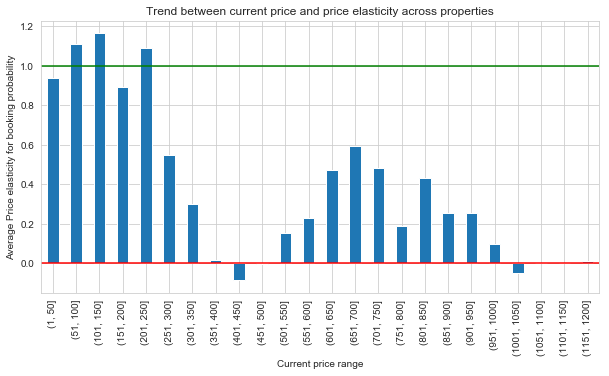

In [329]:
fig, ax = plt.subplots(figsize=(10,5))
bar_ax = tuned_data_1.groupby(["current_price_category"]).mean()['price_elasticity'].iloc[:30,].plot.bar(ax=ax)
bar_ax.set_xlabel("Current price range")
bar_ax.set_ylabel("Average Price elasticity for booking probability")
elasticity_threshold_line = bar_ax.axhline(y=1, color="g")
elasticity_zero_line = bar_ax.axhline(y=0, color="r")
title = bar_ax.set_title("Trend between current price and price elasticity across properties")

In case we choose to treat properties with negative price elasticity as erroneous projection of our model and filter them out before plotting the relationship between price elasticity of booking probability and current price range, the graph would look something like this.

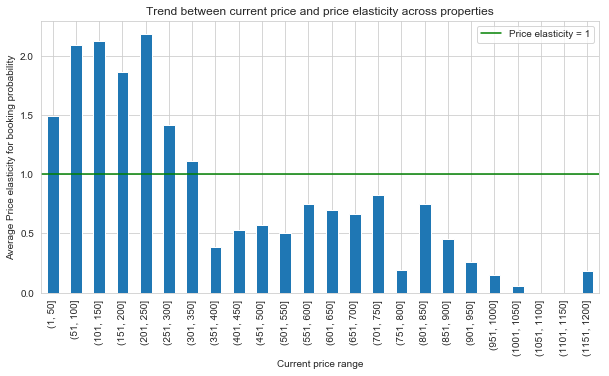

In [328]:
fig, ax = plt.subplots(figsize=(10,5))
bar_ax = tuned_data_1.query("price_elasticity > 0").groupby(["current_price_category"]).mean()['price_elasticity'].iloc[:30,].plot.bar(ax=ax)
bar_ax.set_xlabel("Current price range")
bar_ax.set_ylabel("Average Price elasticity for booking probability")
elasticity_threshold_line = bar_ax.axhline(y=1, color="g")
bar_ax.legend((elasticity_threshold_line,), ("Price elasticity = 1",))
title = bar_ax.set_title("Trend between current price and price elasticity across properties")

The properties in price range of 1 to 300 are showing maximum price elasticity for probability of booking. This means that properties in these price ranges should be considered as first choice for applying price tuning algorithm to maximize expected revenue.

## How does price elasticity for booking probability varies with time across the year?


We have seen earlier in our exploratory analysis that there are visible changes in the average price of properties across the year. Does it have impact on the price elasticity of demand for properties? Let's have a look.

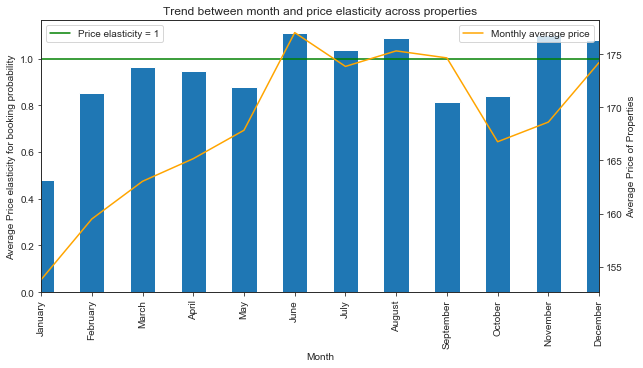

In [336]:
tuned_data_1["month"] = ""
tuned_data_1["month_num"] = 13
months = []
for month in [col.replace("month_", "") for col in tuned_data_1.columns if col.startswith("month") and col not in ["month", "month_num"] ]:
  query = f"month_{month}"
  months_ordered = ["January", 
                    'February', 'March', 'April', 'May', 'June', 'July', 
                    "August","September", "October", "November", "December",  "nan"]
  tuned_data_1.loc[tuned_data_1[query] == 1, "month"] = month
  tuned_data_1.loc[tuned_data_1[query] == 1, "month_num"] = months_ordered.index(month) + 1
  
fig, ax = plt.subplots(figsize=(10,5))  
sns.set_style("ticks")
bar_ax = tuned_data_1.sort_values(by=["month_num"]).groupby(["month"], sort=False).mean()['price_elasticity'].plot.bar(ax=ax)
bar_ax.set_xlabel("Month")
bar_ax.set_ylabel("Average Price elasticity for booking probability")

ax_2 = ax.twinx()
bar_ax_2 = tuned_data_1.sort_values(by=["month_num"]).groupby(["month"], sort=False).mean()['current_price'].plot(ax=ax_2, color="orange")
bar_ax_2.set_ylabel("Average Price of Properties")
bar_ax_2.legend(["Monthly average price"], loc=0)
elasticity_1_threshold_line = bar_ax.axhline(y=1, color="g")
bar_ax.legend((elasticity_1_5_threshold_line,), ("Price elasticity = 1",))
title = bar_ax.set_title("Trend between month and price elasticity across properties")

It's evident from the above graph that this sample demonstrates highest price elasticity for booking probability in the month of **November** & **July**, the middle month of summer and November. However it also remains consistently above 0.4 in all the months.

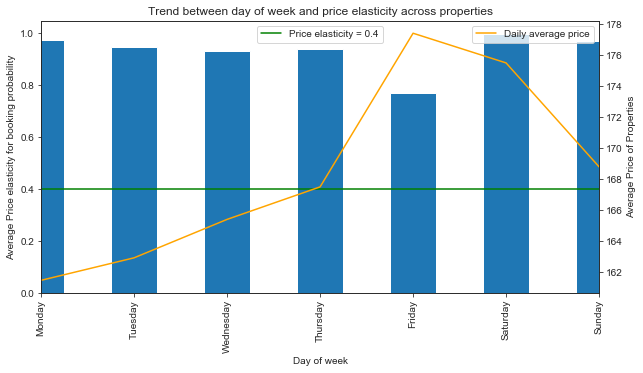

In [340]:
tuned_data_1["day_of_week"] = ""
tuned_data_1["day_of_week_num"] = 8
for day_of_week in [col.replace("day_of_week_", "") for col in tuned_data_1.columns if col.startswith("day_of_week_") and col not in ["day_of_week", "day_of_week_num"] ]:
  query = f"day_of_week_{day_of_week}"
  days_of_week_ordered = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday", "nan"]
  tuned_data_1.loc[tuned_data_1[query] == 1, "day_of_week"] = day_of_week
  tuned_data_1.loc[tuned_data_1[query] == 1, "day_of_week_num"] = days_of_week_ordered.index(day_of_week) + 1
 
fig, ax = plt.subplots(figsize=(10,5))  
bar_ax = tuned_data_1.sort_values(by=["day_of_week_num"]).groupby(["day_of_week"], sort=False).mean()['price_elasticity'].plot.bar(ax=ax)
bar_ax.set_xlabel("Day of week")
bar_ax.set_ylabel("Average Price elasticity for booking probability")
elasticity_threshold_line = bar_ax.axhline(y=0.4, color="g")
bar_ax.legend((elasticity_threshold_line,), ("Price elasticity = 0.4",))

ax_2 = ax.twinx()
bar_ax_2 = tuned_data_1.sort_values(by=["day_of_week_num"]).groupby(["day_of_week"], sort=False).mean()['current_price'].plot(ax=ax_2, color="orange")
bar_ax_2.set_ylabel("Average Price of Properties")
bar_ax_2.legend(["Daily average price"], loc=0)

title = bar_ax.set_title("Trend between day of week and price elasticity across properties")

It's evident from the above graph that this sample demonstrates highest price elasticity remains almost similar on all the days around the week.

## Finally, for which properties do we choose to tune the prices to maximise expected revenue?


As different properties show different amount of price sensitivity under given day and market condition, we can choose which properties should be considered for tuning prices based on the price elasticity.

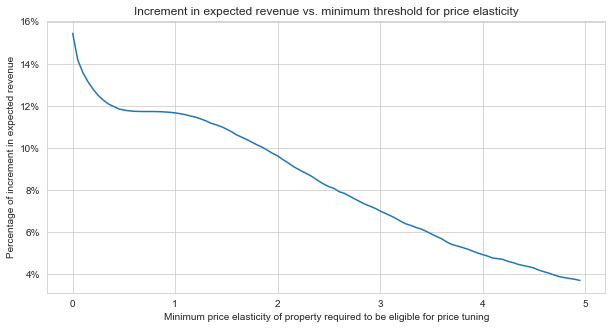

In [319]:
thresholds = list(float_range("0.0", "5.0", "0.05"))
percentage_change_in_expected_revenue = []
for threshold in thresholds:
  expected_revenue_from_props_above_threshold = tuned_data.query("price_elasticity >= @threshold")["expected_revenue_recommended_price"].sum()
  expected_revenue_from_props_below_threshold = tuned_data.query("price_elasticity < @threshold")["expected_revenue_current_price"].sum()
  expected_revenue_from_all_at_current_price = tuned_data["expected_revenue_current_price"].sum()
  change = (expected_revenue_from_props_below_threshold + expected_revenue_from_props_above_threshold - expected_revenue_from_all_at_current_price)/expected_revenue_from_all_at_current_price
  percentage_change_in_expected_revenue.append(change)

fig, ax = plt.subplots(figsize=(10,5))
sns.set_style("whitegrid")
ax = sns.lineplot(x=list(thresholds), y=percentage_change_in_expected_revenue, ax=ax)
ax.set_xlabel("Minimum price elasticity of property required to be eligible for price tuning")
ax.set_ylabel("Percentage of increment in expected revenue")
vals = ax.get_yticks()
yticks = ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
title = ax.set_title("Increment in expected revenue vs. minimum threshold for price elasticity")

- If we choose to tune all the properties with positive price elasticity in our sample, the projected percentage of change in expected revenue according to XGBoost predictor is near ___%.
- If instead, we choose to tune prices for only those properties with price elasticity greater than ___, then projected percentage of change in expected revenue is ____%.

In [330]:
def calc_revenue_at_tuned_price(row, calc_prob_booked):  
    current_price_norm = row["price_calendar_normalized"]
    current_price = current_price_norm * row["total_env_prices"]
    prob_booked = calc_prob_booked(row)    
#     print("price_calendar: " + str(current_price))
    
    # minimum_elasticity to be eligible for tuning the price, 
    # keeping it high will require the booking probability of property 
    # to be more elastic to the price.
    # It will keep the algorithm more realistic to project expected revenue
    minimum_elasticity = 0.4 
    percentage_to_check = 20
    
    curve = get_price_elasticity_curve(listing=row, calc_prob_booked=calc_prob_booked, percentage=percentage_to_check)
        
#     print ("Checking for price elasticity...")
    row["price_calendar_normalized"] = current_price_norm
    elasticity = calculate_price_elasticity(curve, listing=row, percentage_to_check=percentage_to_check)    
    if elasticity > minimum_elasticity:          
        print ("Elasticity demonstrated: " + str(np.round(elasticity, 3)))
        print("✔ The property follows significant price elasiticity in reasonable price range according to model")

        print ("Probability of being booked at current price: " + str(prob_booked))
        row["price_calendar_normalized"] = current_price_norm
        current_expected_revenue = current_price * prob_booked        
        print ("")
        print("Current price: " + str(round(current_price, 0)))
        print("Probability of being booked at current price: " + str(prob_booked))
        print("Expected revenue at current price: " + str(current_expected_revenue))       
        
        max_expected_revenue = -math.inf
        prob_at_max = None
        price_at_max = None
        lower_price_normalized = max(current_price_norm * (1 - percentage_to_check/100), 0)
        higher_price_normalized = current_price_norm * (1 + percentage_to_check/100)
        for trial_price_norm in float_range(str(lower_price_normalized), str(higher_price_normalized), str((higher_price_normalized-lower_price_normalized)/100)):
          # Instead of using probability predicted by the classifier,
          # I decided to use the one derived from line fitted on the values
          # in normalized price range near the current normalized price
          # so that I can have a smoothly varying values which avoid sudden
          # bumps in the probability values often seen to be generated by
          # ensemble learners.
#             row["price_calendar_normalized"] = trial_price_norm
#             prob_at_trial_price_norm = calc_prob_booked(row)
            df_trial = pd.DataFrame(data={"x" : trial_price_norm}, index=[0])
            prob_at_trial_price_norm = curve.predict(df_trial)[0]   
            expected_revenue = prob_at_trial_price_norm * trial_price_norm * row["total_env_prices"]
            if expected_revenue > max_expected_revenue:
                max_expected_revenue = expected_revenue
                prob_at_max = prob_at_trial_price_norm
                price_at_max = trial_price_norm * row["total_env_prices"]
        draw_price_elasticity_for_prop(row, calc_prob_booked, percentage_to_check, curve, rec_price=round(price_at_max,0))
        print ("Recommended price: " + str(round(price_at_max,0)))
        print ("Probability of booked at recommended price: " + str(np.round(prob_at_max, 5)))
        print ("Expected revenue at recommended price: " + str(np.round(max_expected_revenue,2)))
        print ("Percentage of recommended price change: " + str(np.round(100*(price_at_max - current_price)/current_price, 3)) +"%")
        print ("Percentage of change in expected revenue: " + str(np.round(100*(max_expected_revenue - current_expected_revenue)/current_expected_revenue, 2)) +"%")
        print ("----------------------------------------------------------------")
        return max_expected_revenue
    else:
#         print("✘ The property does not follow desired price elasiticity in reasonable price range according to model")
        return current_price * prob_booked

Elasticity demonstrated: [1.843]
✔ The property follows significant price elasiticity in reasonable price range according to model
Probability of being booked at current price: 0.23616666

Current price: 145.0
Probability of being booked at current price: 0.23616666
Expected revenue at current price: 34.22054845690727
Price elasticity plot for a property of
Size: 847.3085106382979sq.ft
Accommodates: 4
Bedrooms: 1.0


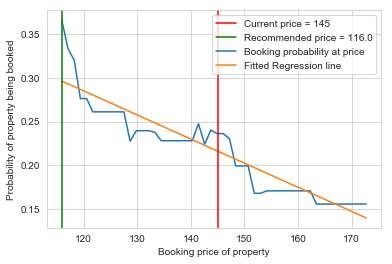

Recommended price: 116.0
Probability of booked at recommended price: [0.29628]
Expected revenue at recommended price: [34.35]
Percentage of recommended price change: -20.0%
Percentage of change in expected revenue: [0.36]%
----------------------------------------------------------------
Elasticity demonstrated: [1.94]
✔ The property follows significant price elasiticity in reasonable price range according to model
Probability of being booked at current price: 0.13721484

Current price: 145.0
Probability of being booked at current price: 0.13721484
Expected revenue at current price: 19.882430237531658
Price elasticity plot for a property of
Size: 847.3085106382979sq.ft
Accommodates: 4
Bedrooms: 1.0


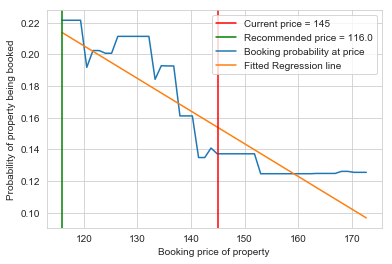

Recommended price: 116.0
Probability of booked at recommended price: [0.21389]
Expected revenue at recommended price: [24.79]
Percentage of recommended price change: -20.0%
Percentage of change in expected revenue: [24.7]%
----------------------------------------------------------------
Elasticity demonstrated: [2.878]
✔ The property follows significant price elasiticity in reasonable price range according to model
Probability of being booked at current price: 0.03108573

Current price: 149.0
Probability of being booked at current price: 0.03108573
Expected revenue at current price: 4.621826276779175
Price elasticity plot for a property of
Size: 847.3085106382979sq.ft
Accommodates: 4
Bedrooms: 1.0


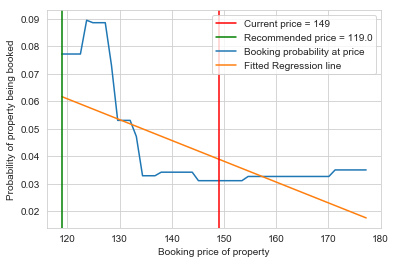

Recommended price: 119.0
Probability of booked at recommended price: [0.06171]
Expected revenue at recommended price: [7.34]
Percentage of recommended price change: -20.0%
Percentage of change in expected revenue: [58.82]%
----------------------------------------------------------------
Elasticity demonstrated: [1.258]
✔ The property follows significant price elasiticity in reasonable price range according to model
Probability of being booked at current price: 0.34289736

Current price: 295.0
Probability of being booked at current price: 0.34289736
Expected revenue at current price: 101.09985631227492
Price elasticity plot for a property of
Size: 847.3085106382979sq.ft
Accommodates: 7
Bedrooms: 3.0


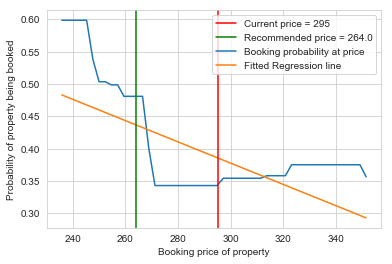

Recommended price: 264.0
Probability of booked at recommended price: [0.43657]
Expected revenue at recommended price: [115.33]
Percentage of recommended price change: -10.4%
Percentage of change in expected revenue: [14.08]%
----------------------------------------------------------------
After tuning prices of porperty listings with price elasticity at least 0.4,
 the change in expected in expected revenue is 7.74%


In [334]:
expected_revenue_at_current_prices = 0
expected_revenue_at_recommended_prices = 0
number_of_properties_to_be_sampled = 10
number_of_properties_with_price_updated = 0
min_price_elasticity_threshold = 0.4
for index, row in tuned_data.query("price_elasticity > 0.4")[X_test.columns].sample(n=number_of_properties_to_be_sampled, random_state=42).copy().iterrows():  
    expected_revenue_at_current_prices += row["price_calendar_normalized"] * row["total_env_prices"] * calc_prob_booked_xgb(row)
    expected_revenue_at_recommended_prices += calc_revenue_at_tuned_price(row, calc_prob_booked=calc_prob_booked_xgb)
    if np.round(expected_revenue_at_current_prices, 2) != np.round(expected_revenue_at_recommended_prices, 2):
      number_of_properties_with_price_updated += 1
percentage_change_in_expected_revenue = 100 * (expected_revenue_at_recommended_prices- expected_revenue_at_current_prices)/(expected_revenue_at_current_prices)
print (f"After tuning prices of porperty listings with price elasticity at least {min_price_elasticity_threshold},\n the change in expected in expected revenue is {str(np.asscalar(np.round(percentage_change_in_expected_revenue, 2)))}%")

In [ ]:
xgb_model = pickle.load(data_dir + "/xgb_best.pkl", "rb")

In [431]:
listing_ids = X_with_env["listing_id"].sample(1000, random_state=42).unique()[:100]

In [432]:
sample_with_env = X_with_env.query("listing_id in @listing_ids").sort_values(by=["listing_id", "date"]).copy().reset_index(drop=True)

In [433]:
is_available = df[["available","listing_id", "date"]].query("listing_id in @listing_ids").sort_values(by=["listing_id", "date"]).drop(columns=["date"]).reset_index(drop=True)

In [434]:
(sample_with_env["listing_id"] == is_available["listing_id"]).all()

True

In [435]:
sample_with_env["is_available"] = is_available["available"]

In [436]:
bin_size = 0.0001
bins = pd.IntervalIndex.from_tuples([(x, x+bin_size-0.00001) for x in float_range("0", "1", str(bin_size))])
sample_with_env["price_calendar_normaliazed_category"] = pd.cut(sample_with_env["price_calendar_normalized"], bins)

/Users/atharva/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


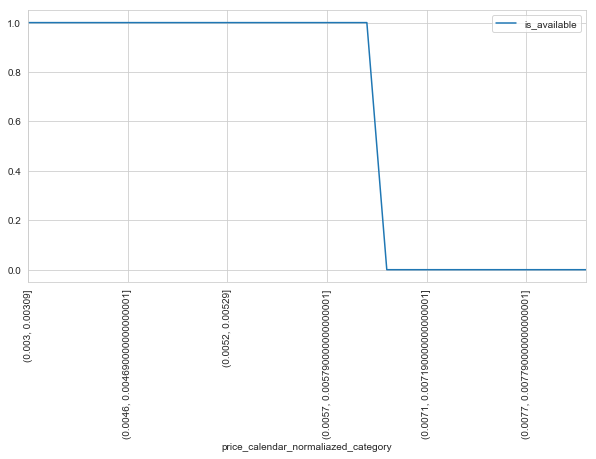

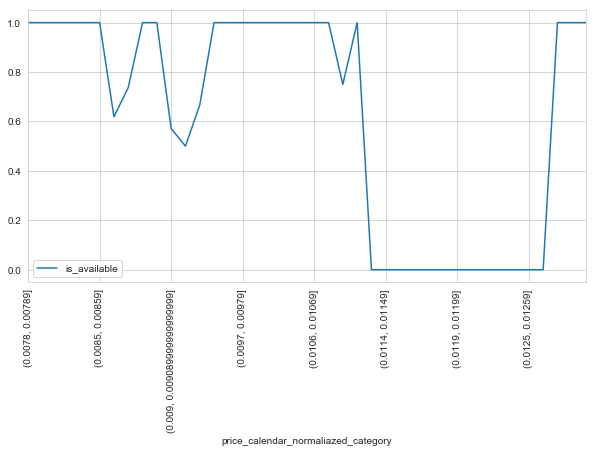

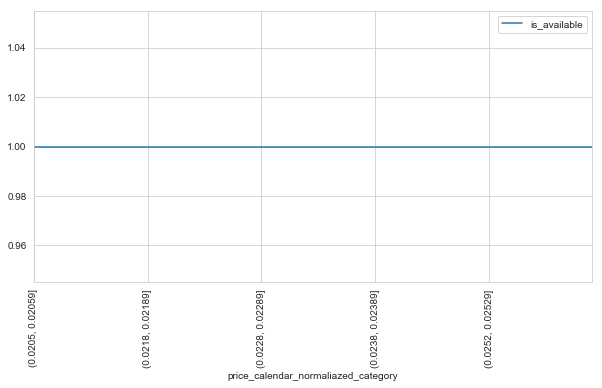

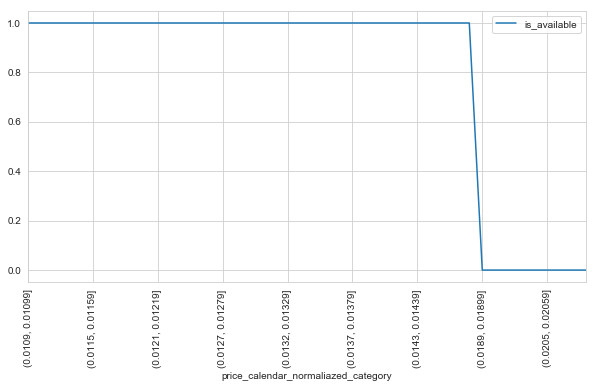

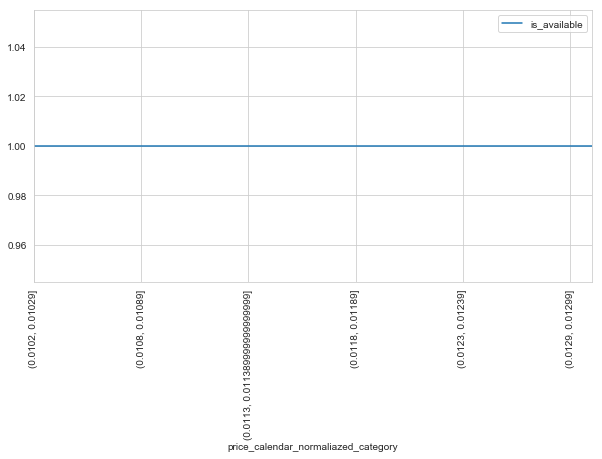

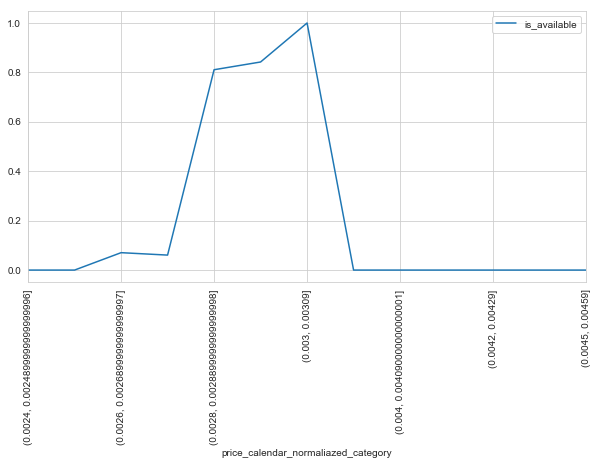

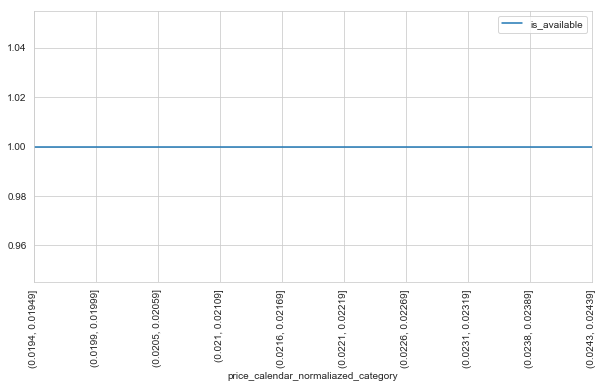

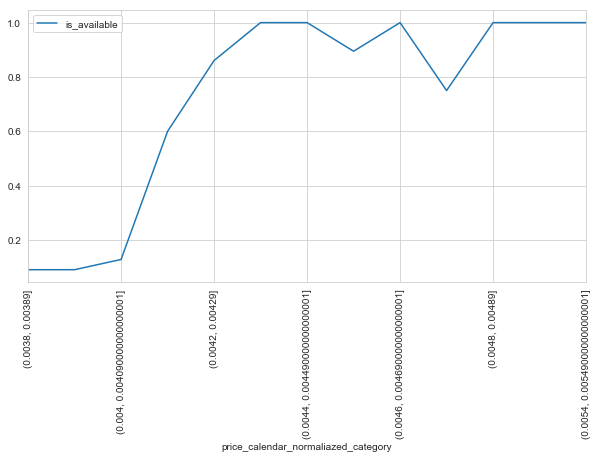

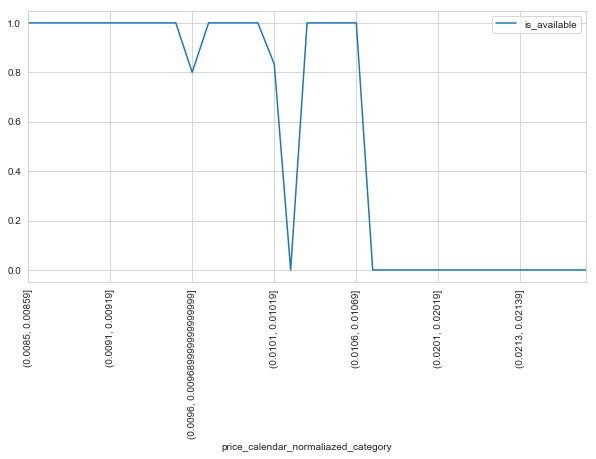

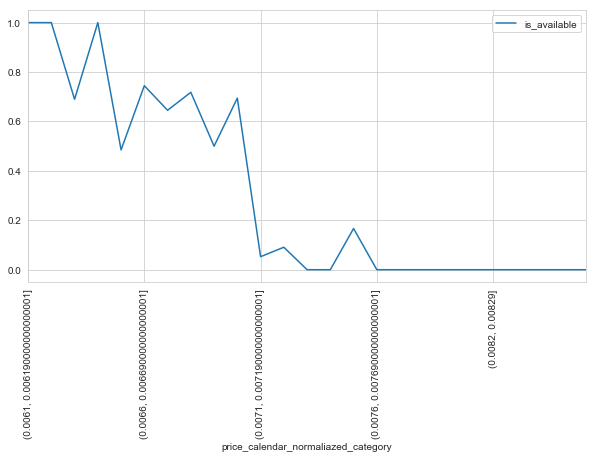

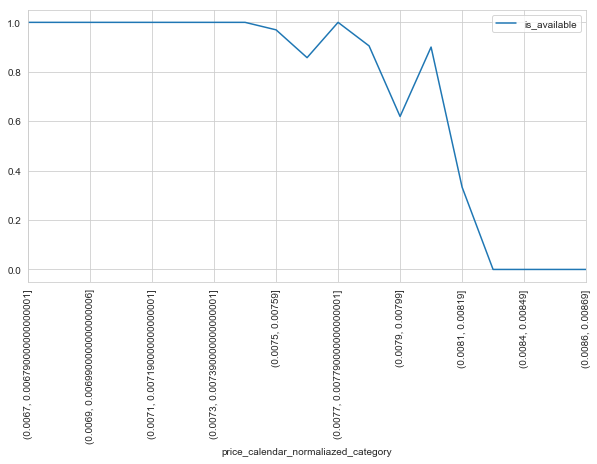

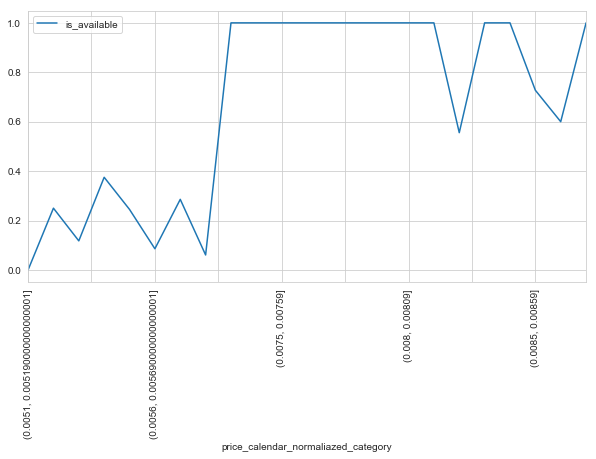

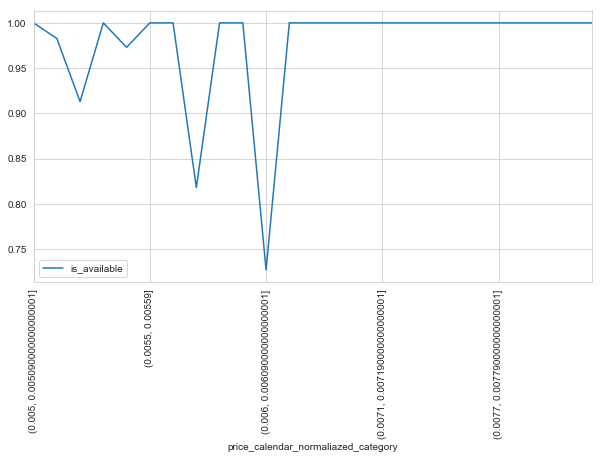

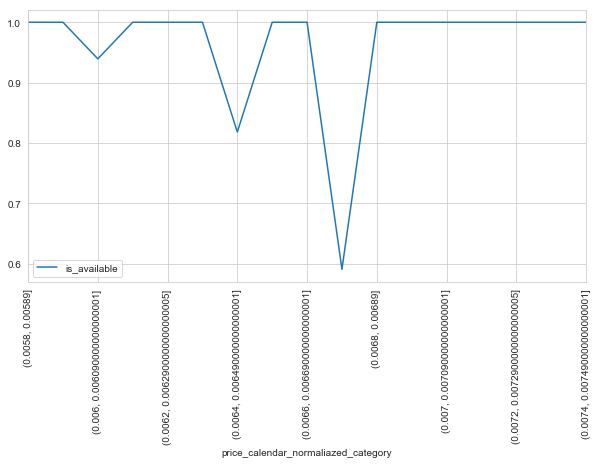

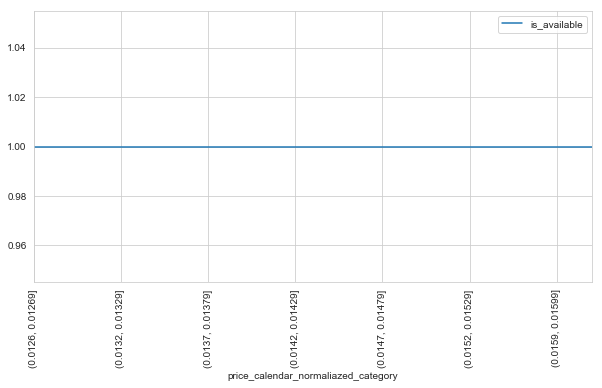

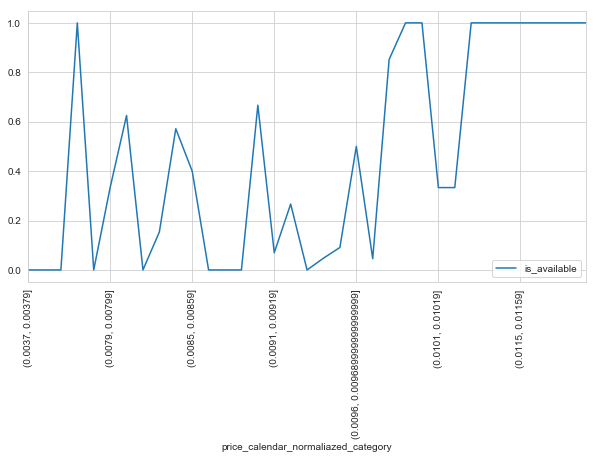

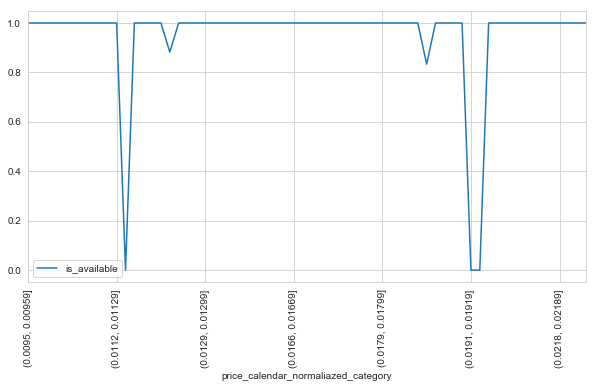

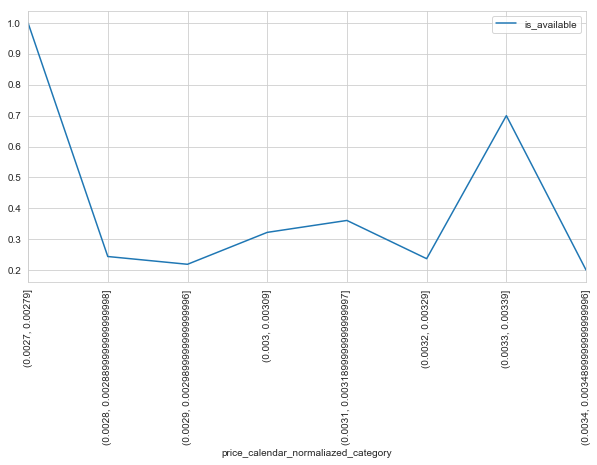

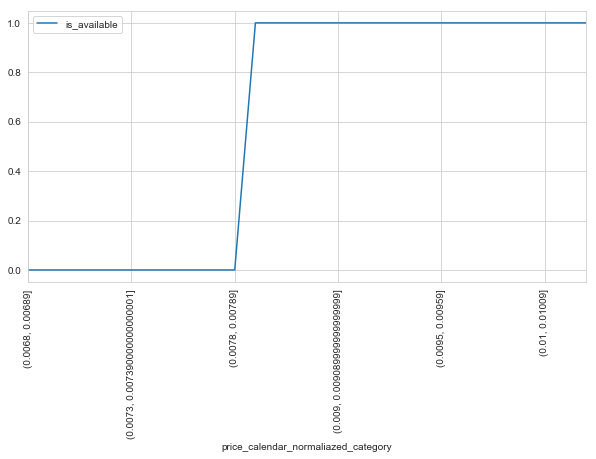

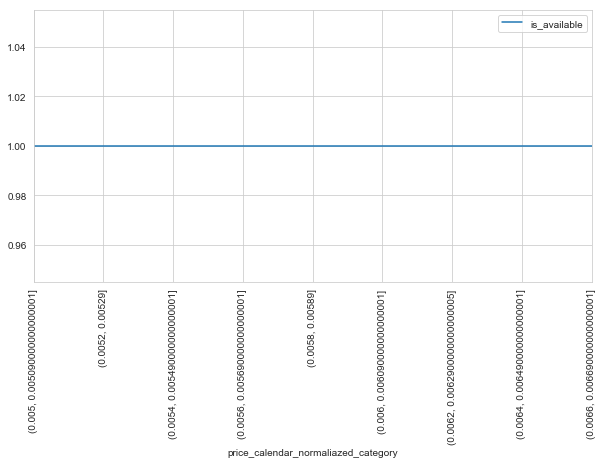

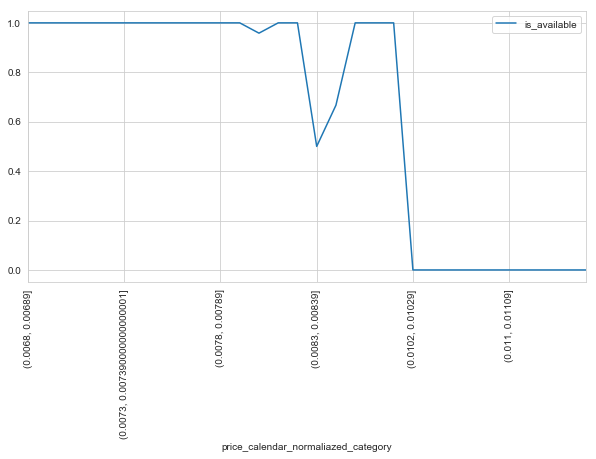

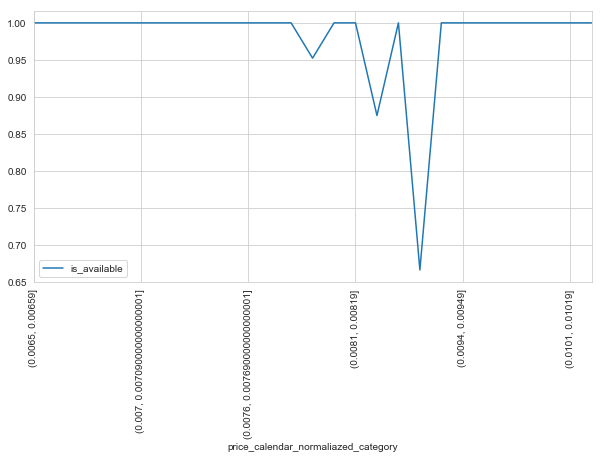

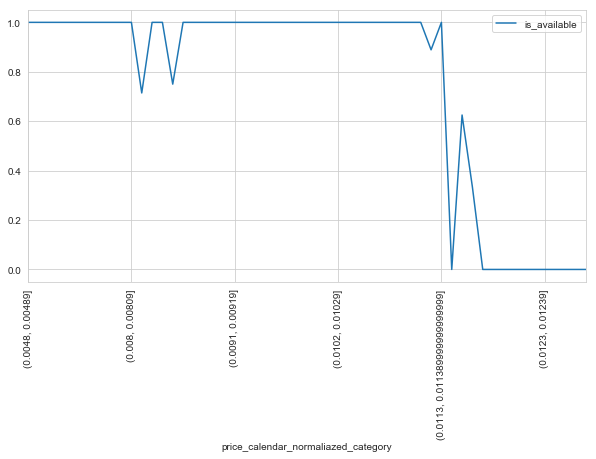

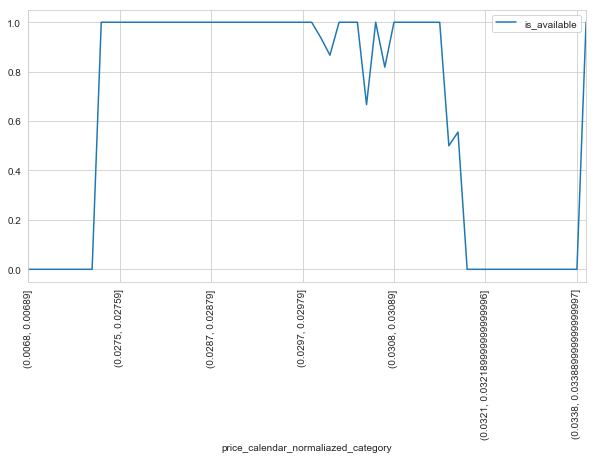

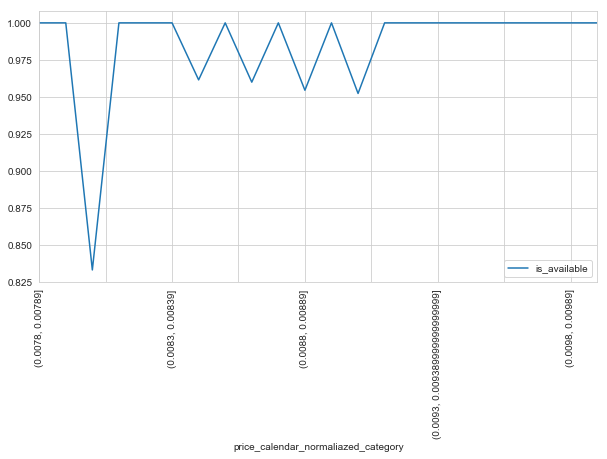

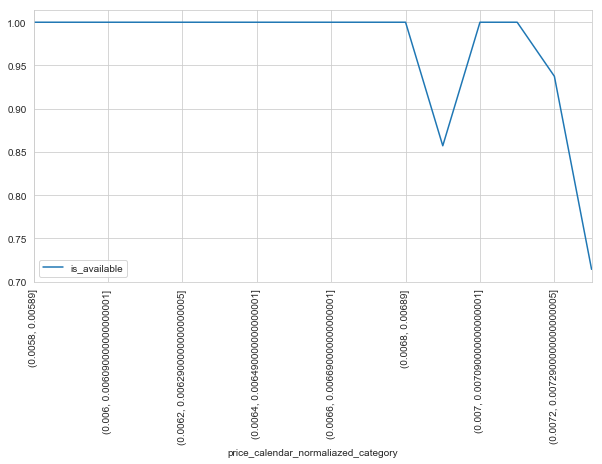

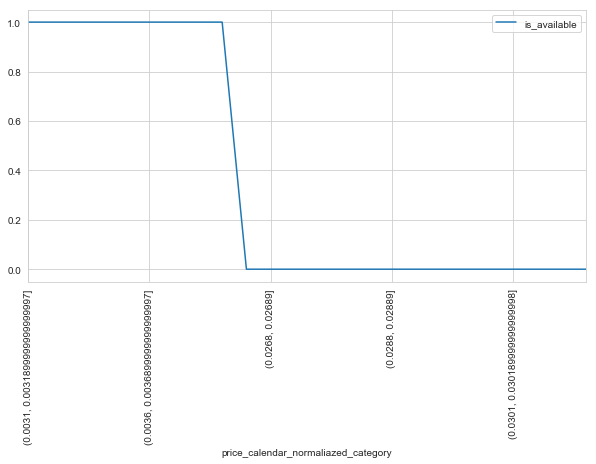

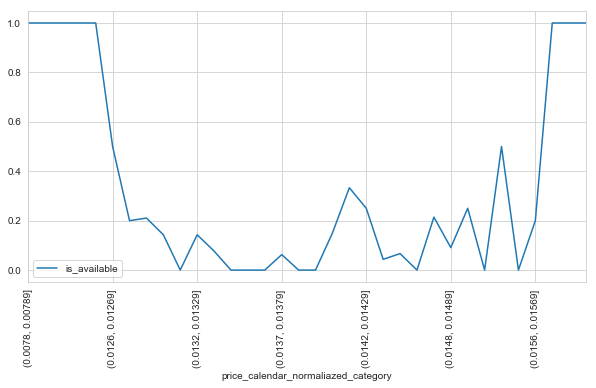

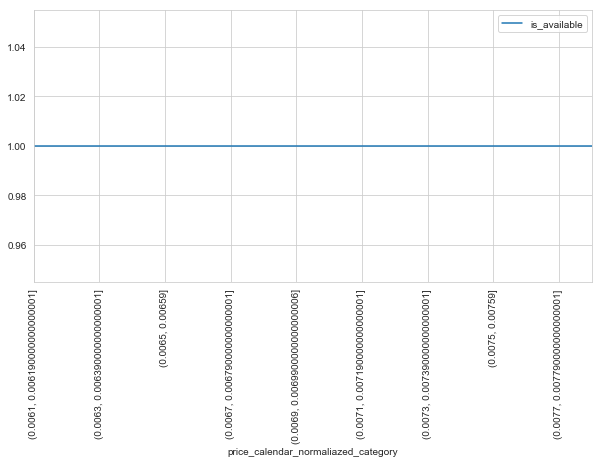

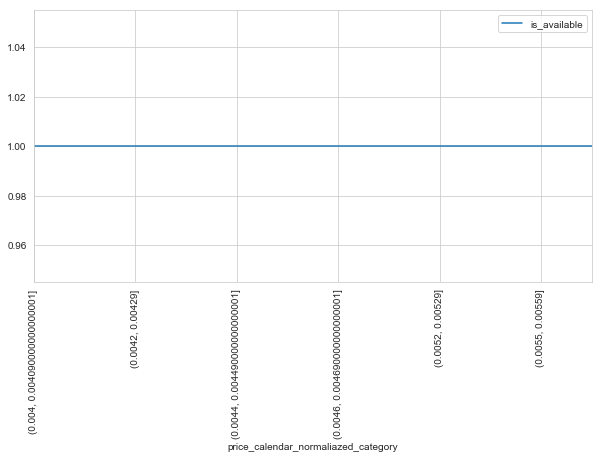

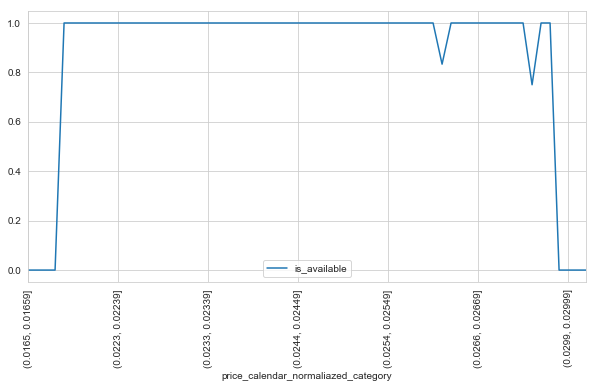

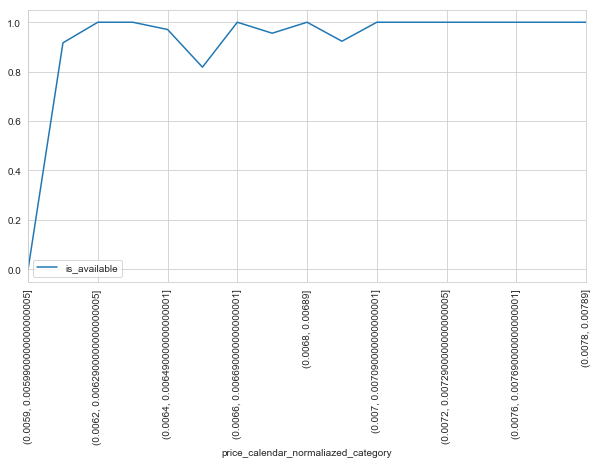

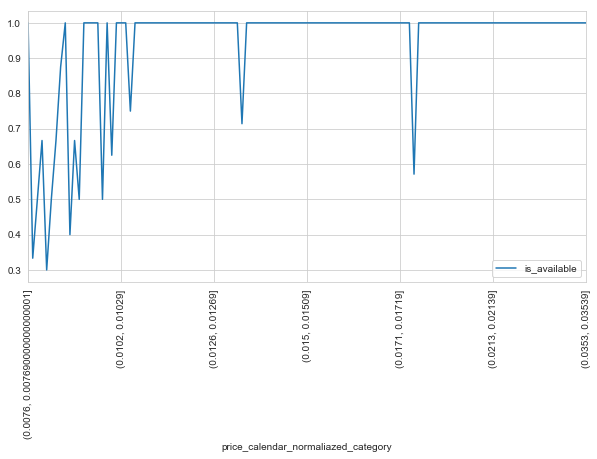

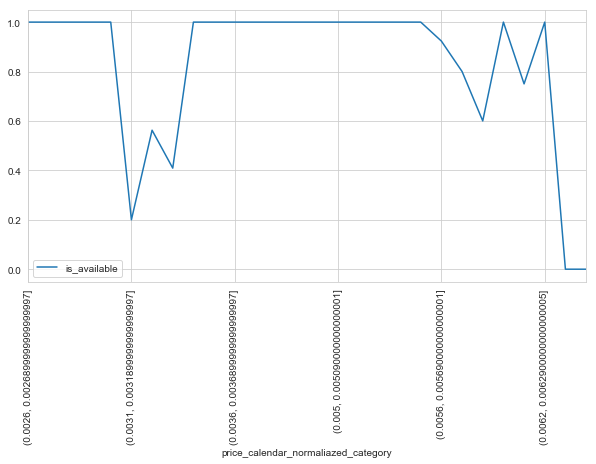

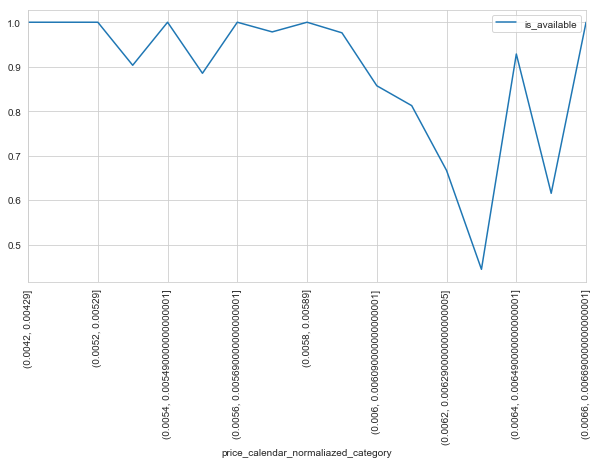

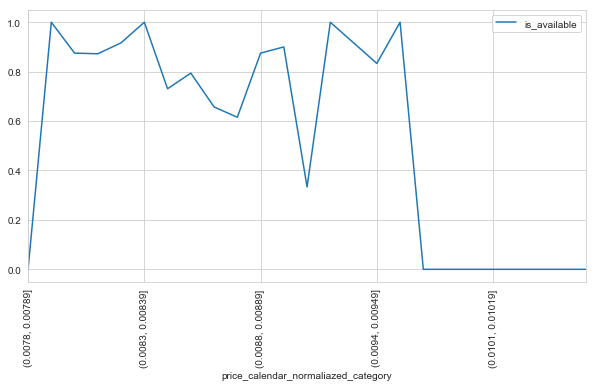

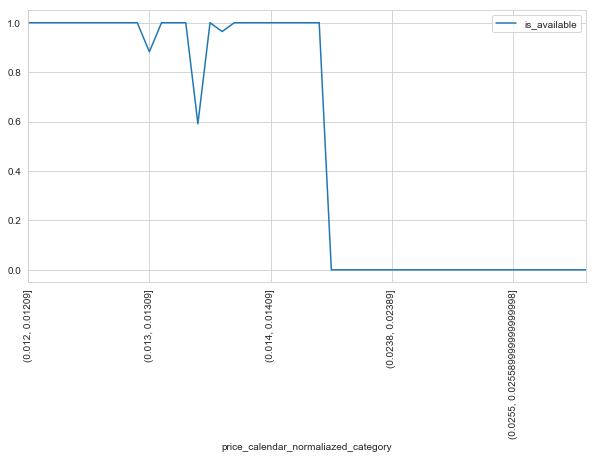

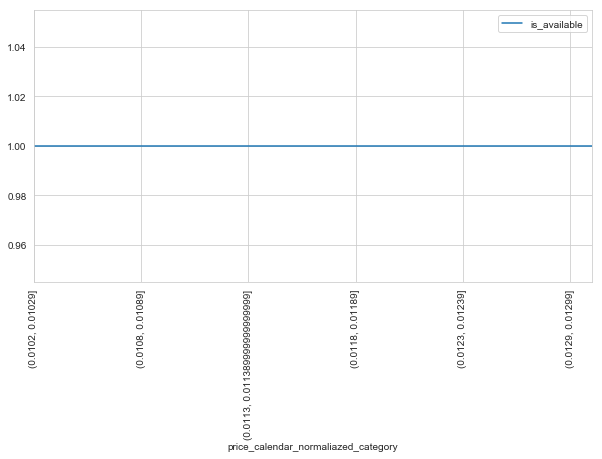

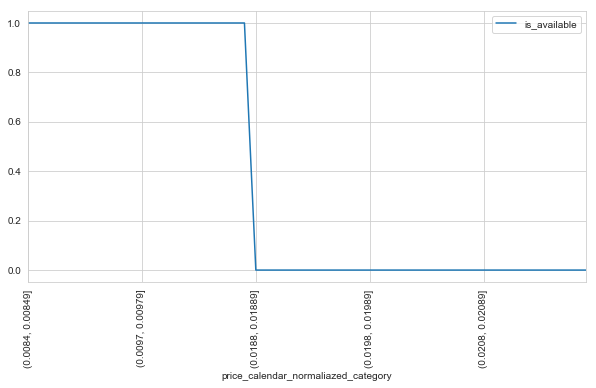

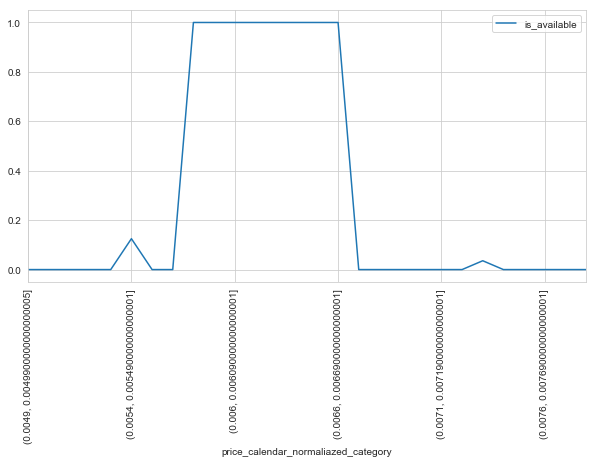

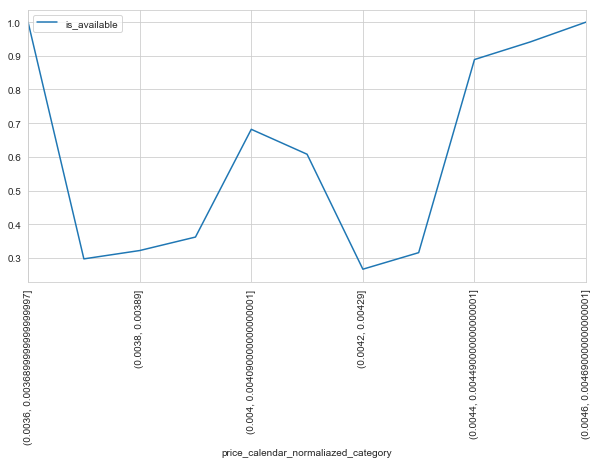

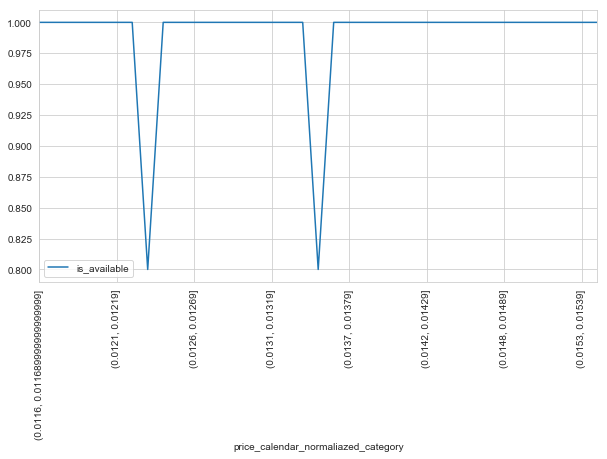

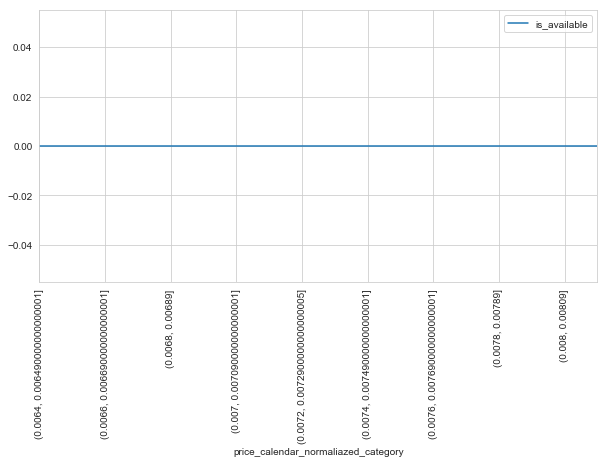

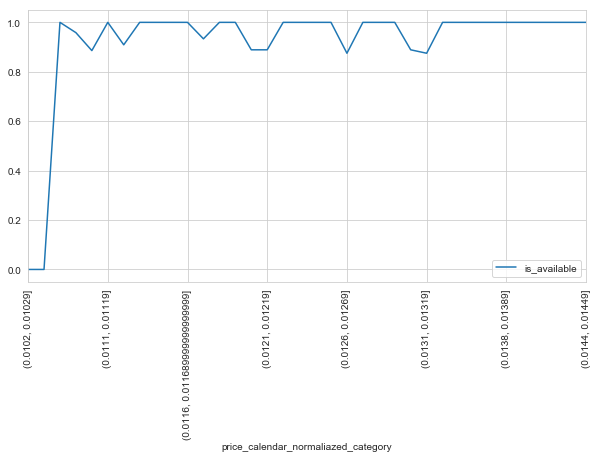

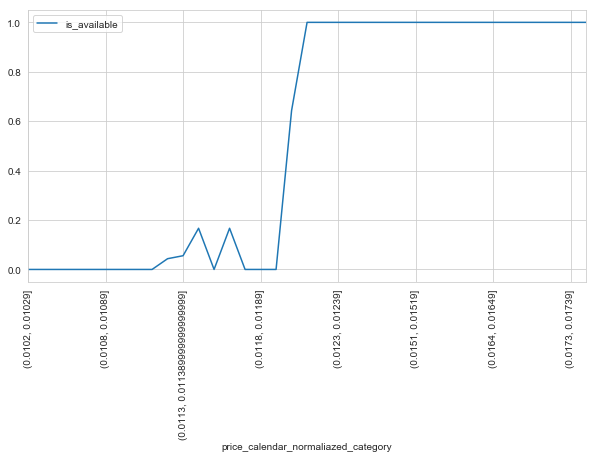

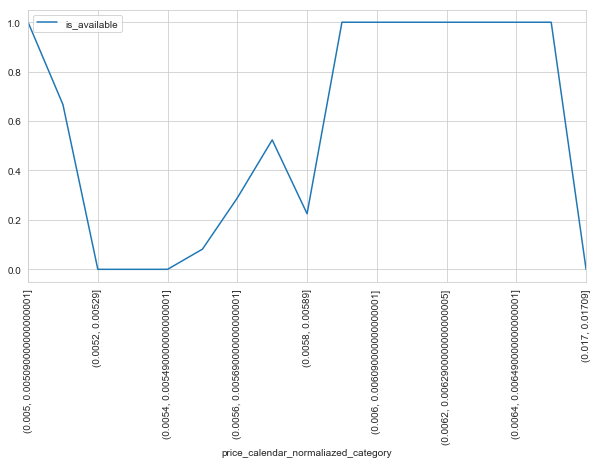

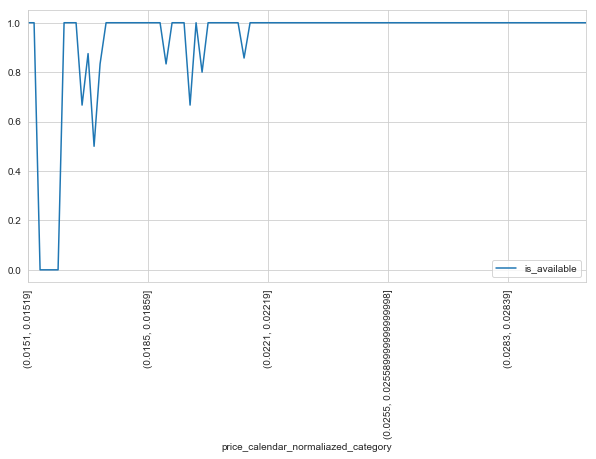

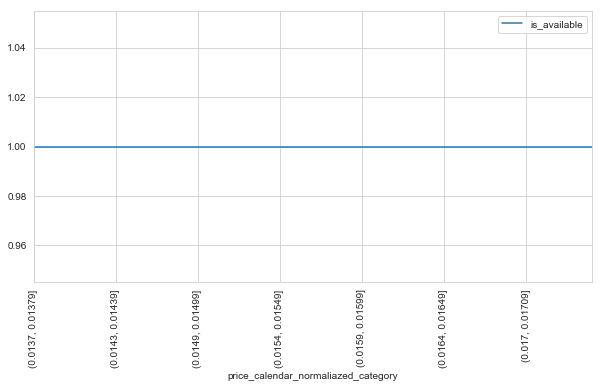

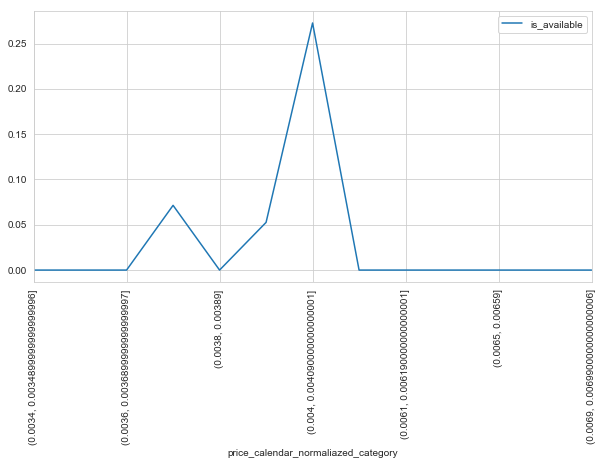

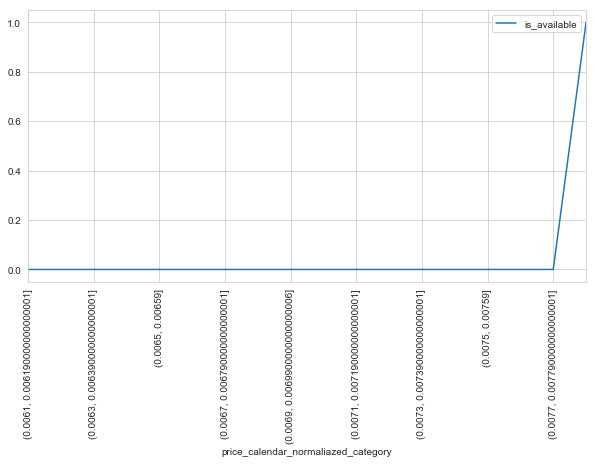

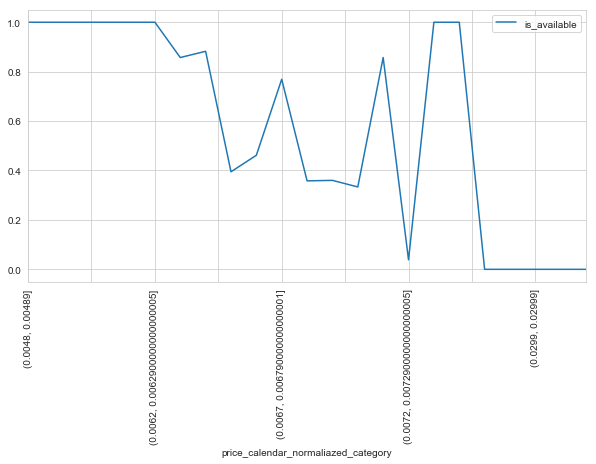

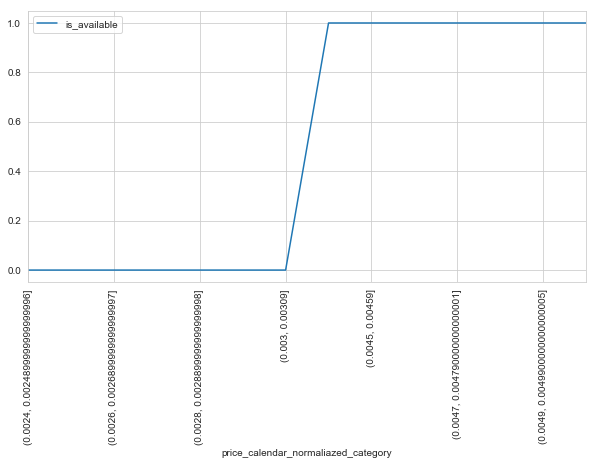

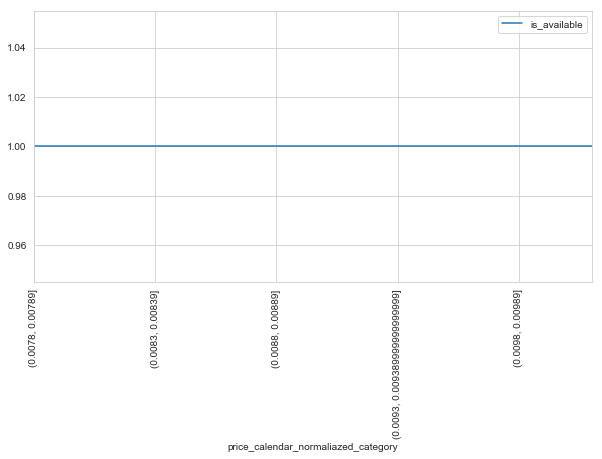

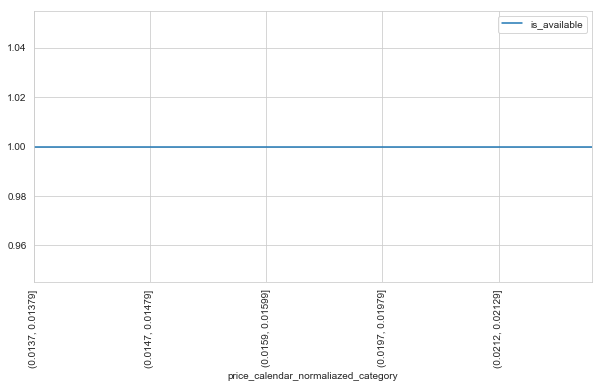

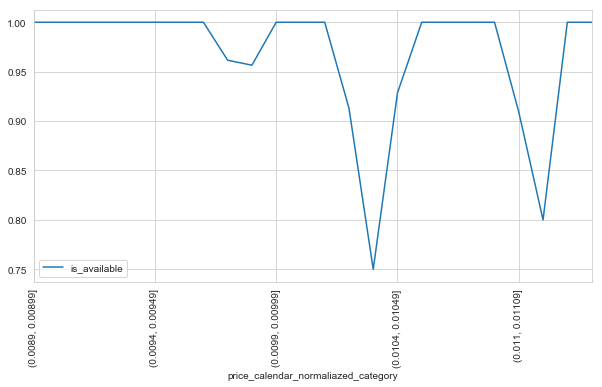

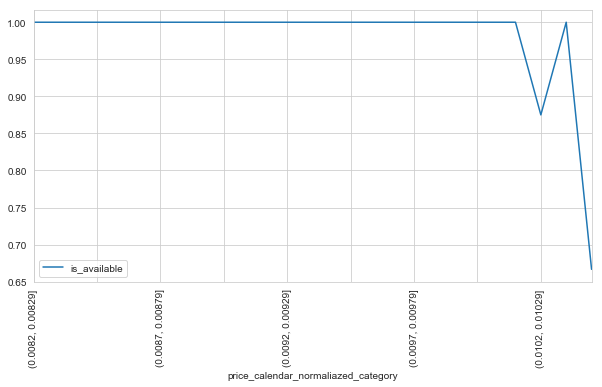

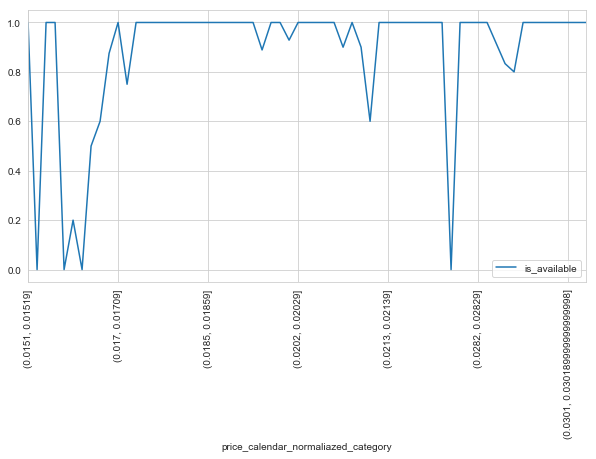

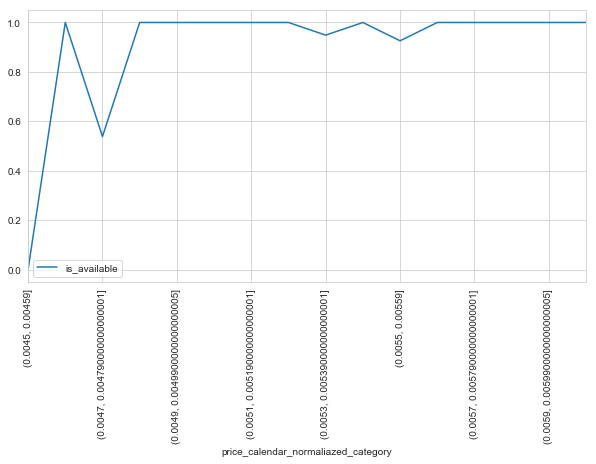

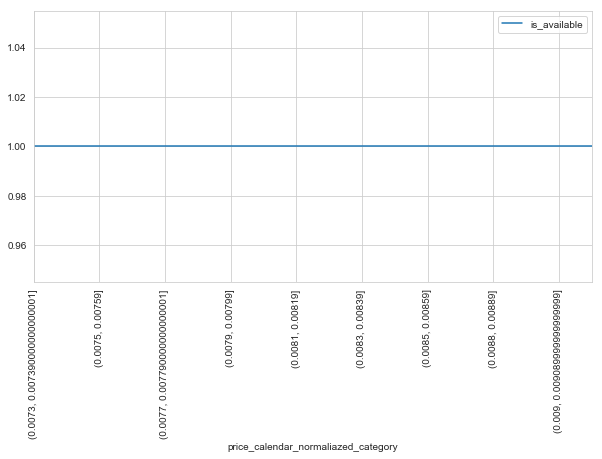

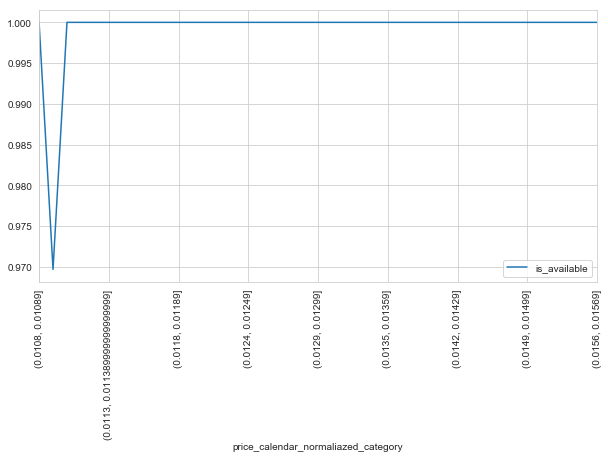

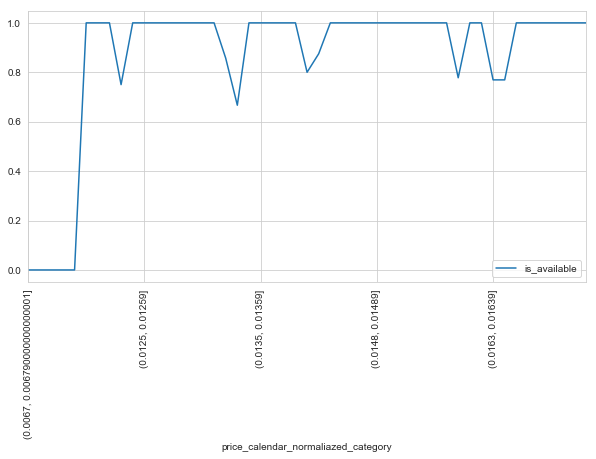

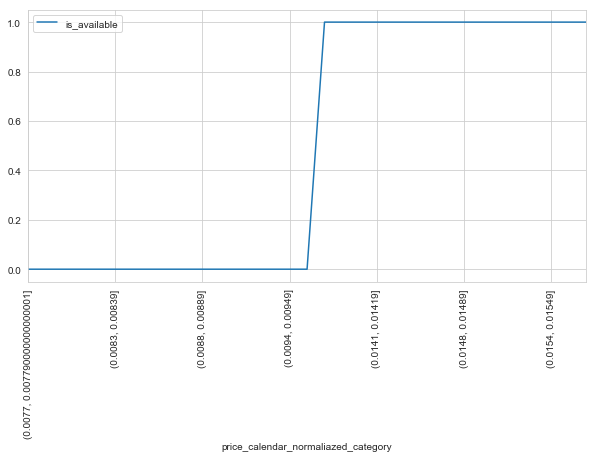

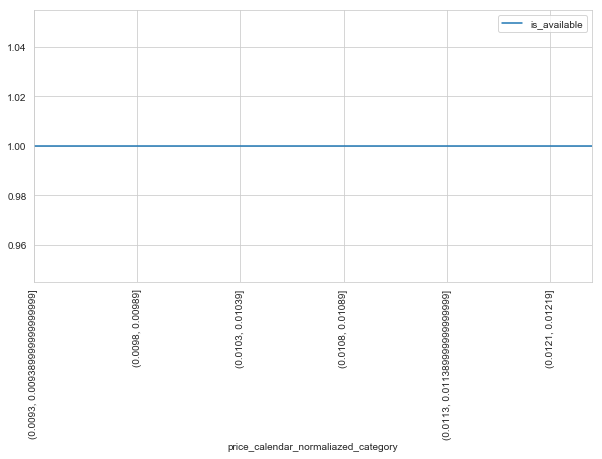

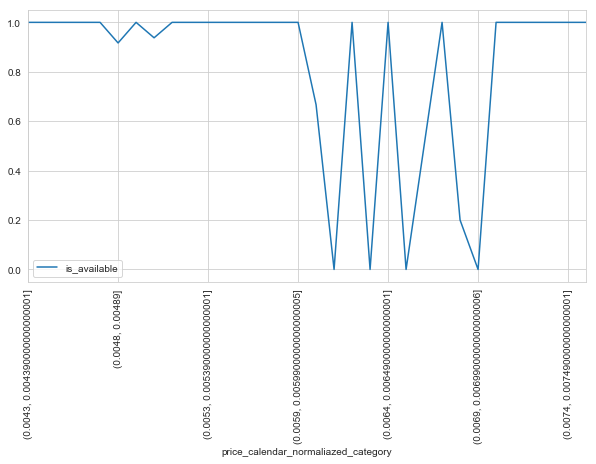

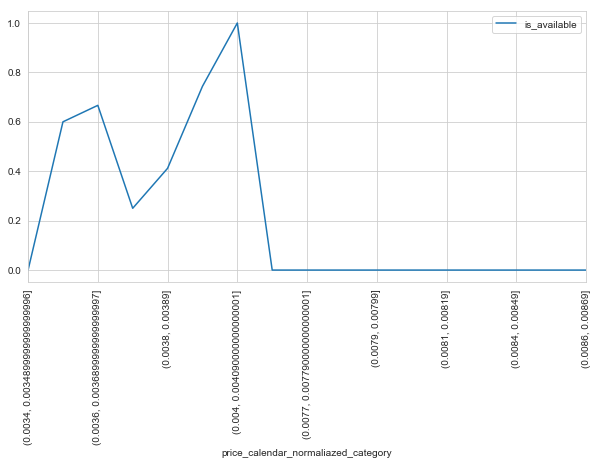

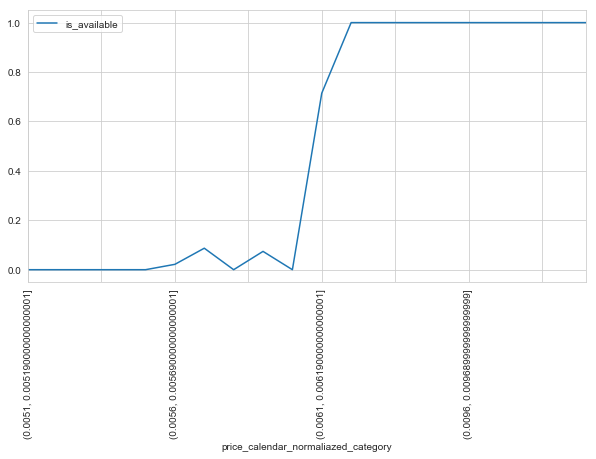

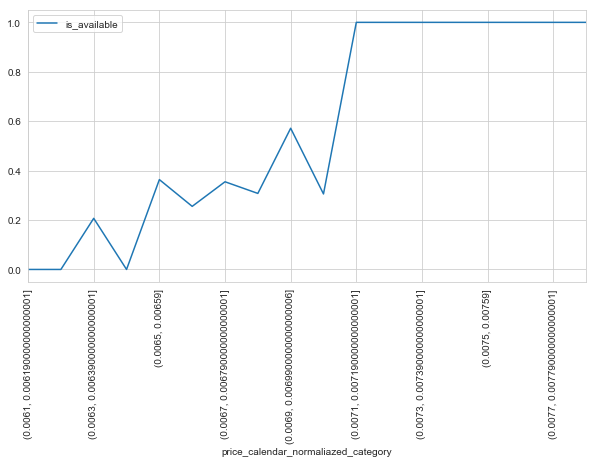

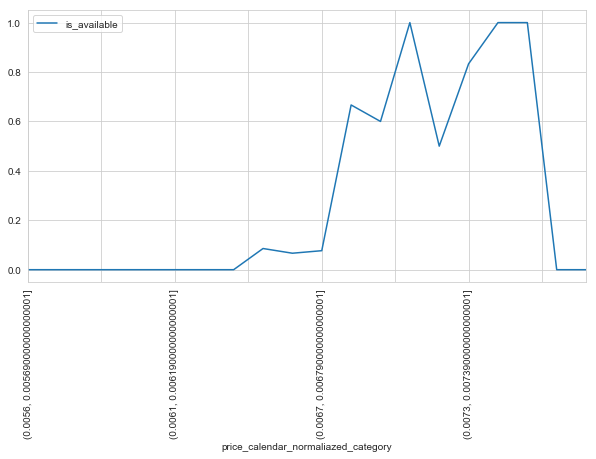

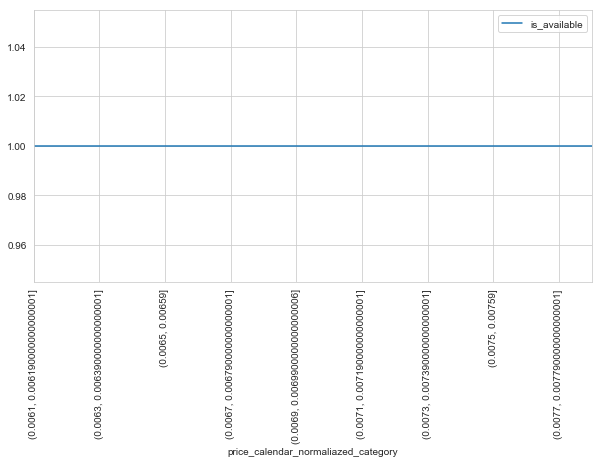

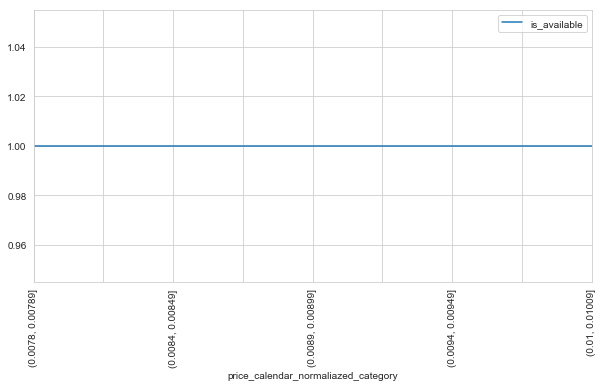

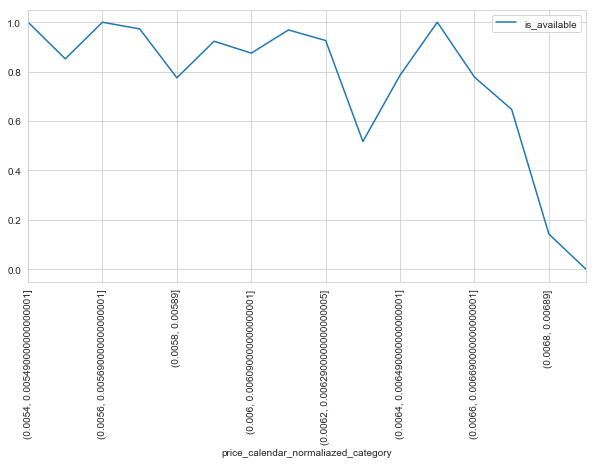

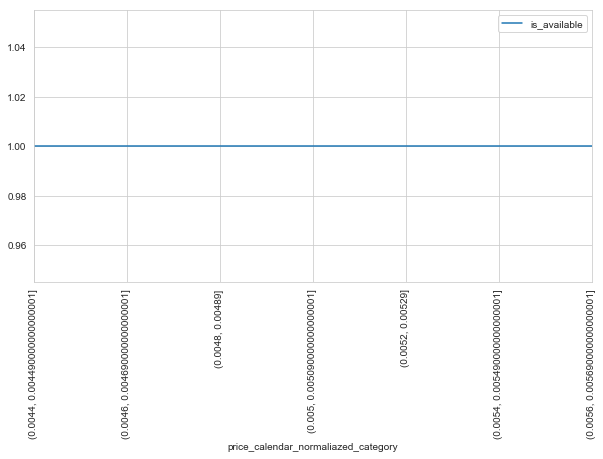

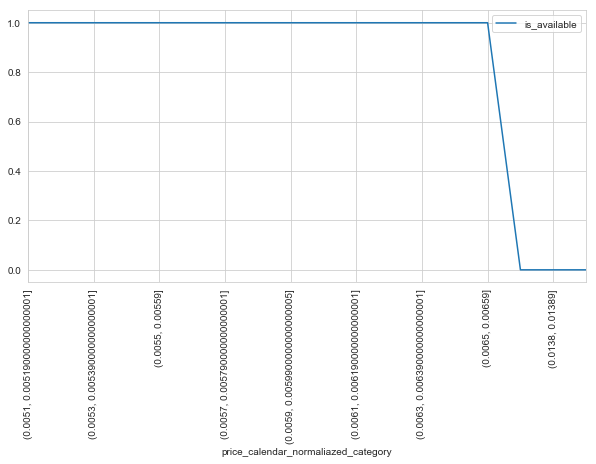

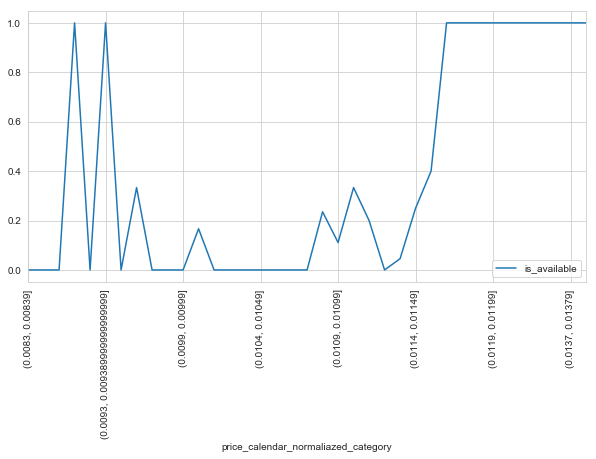

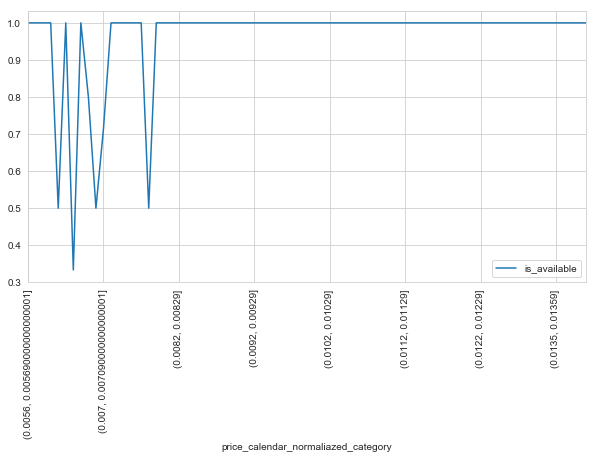

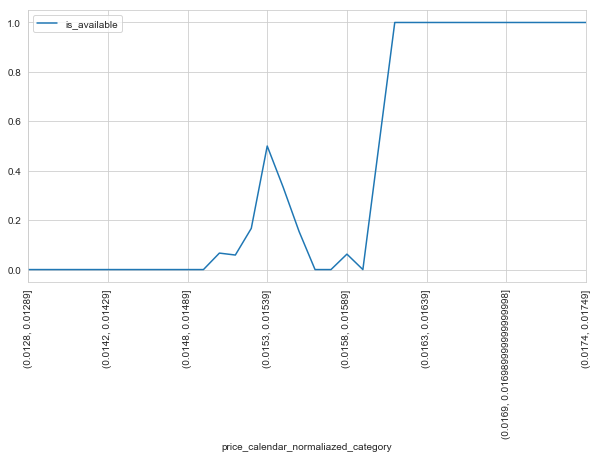

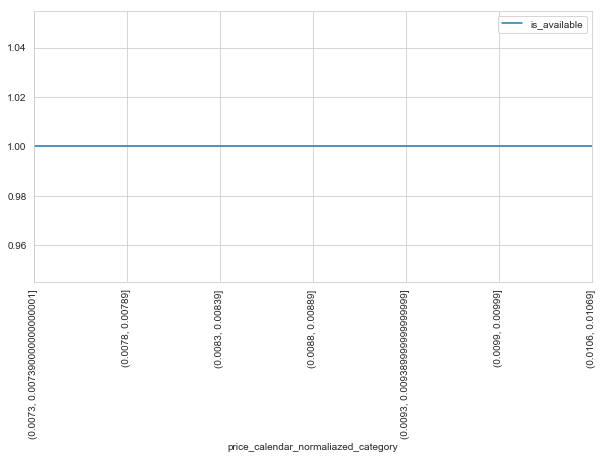

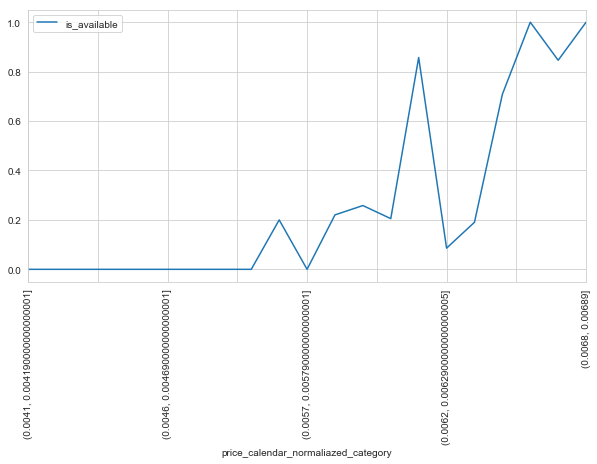

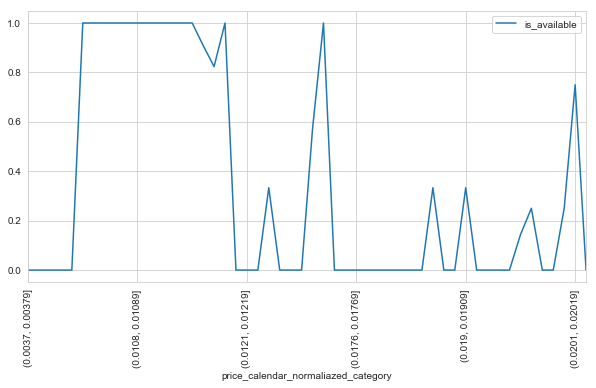

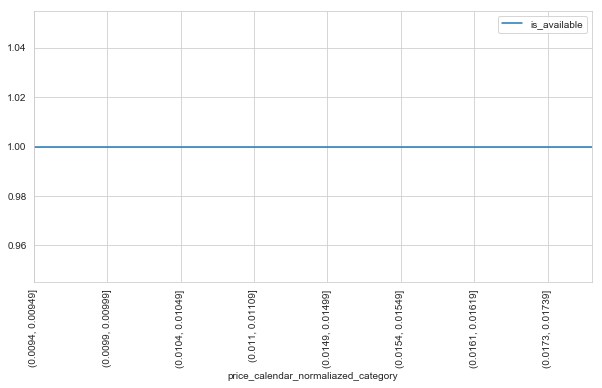

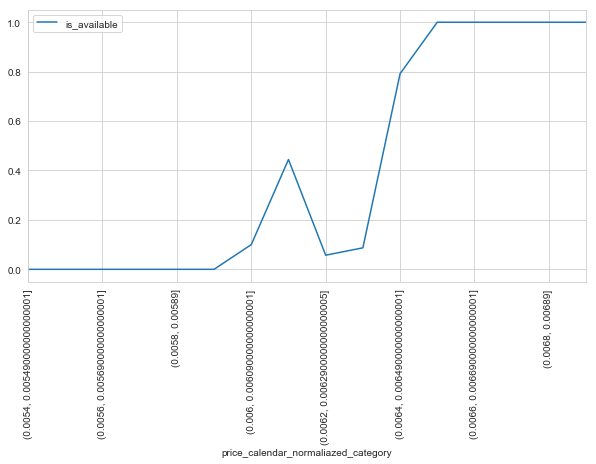

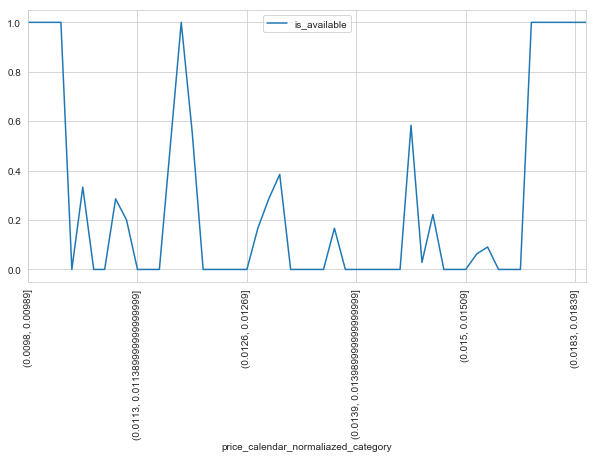

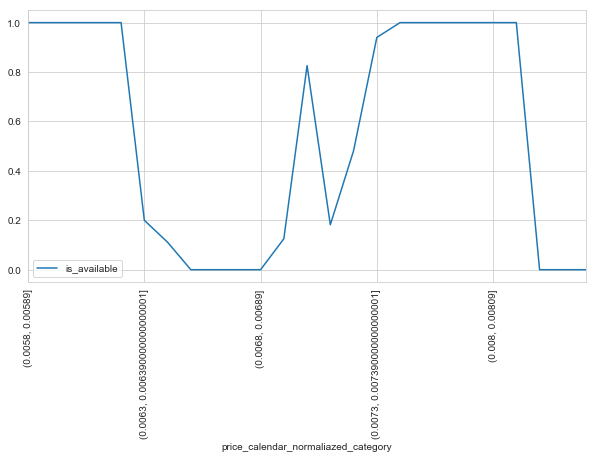

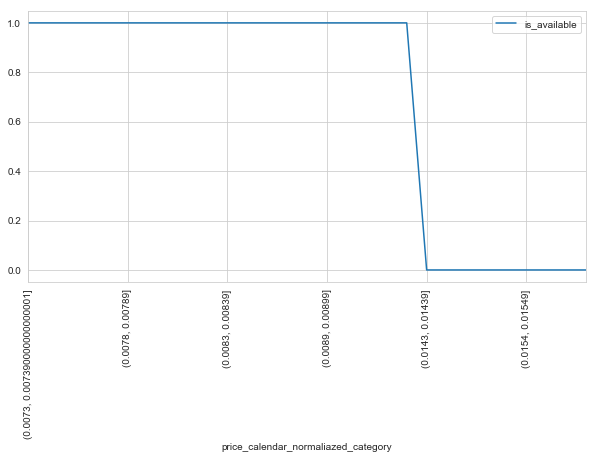

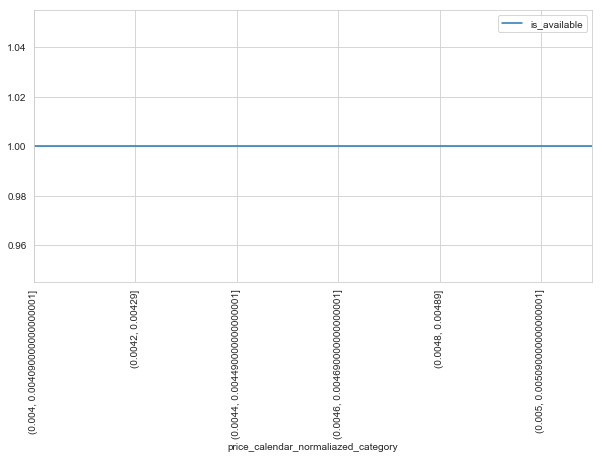

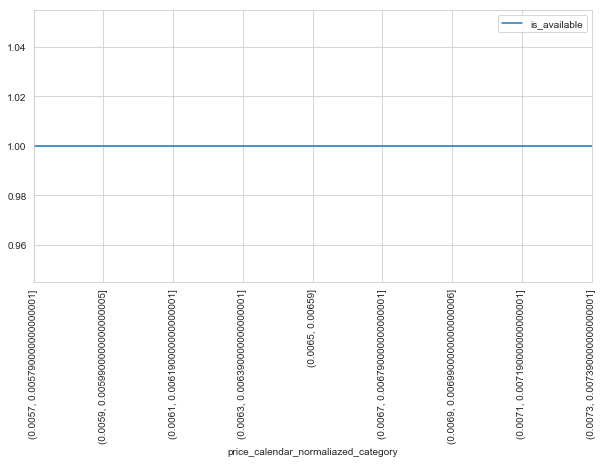

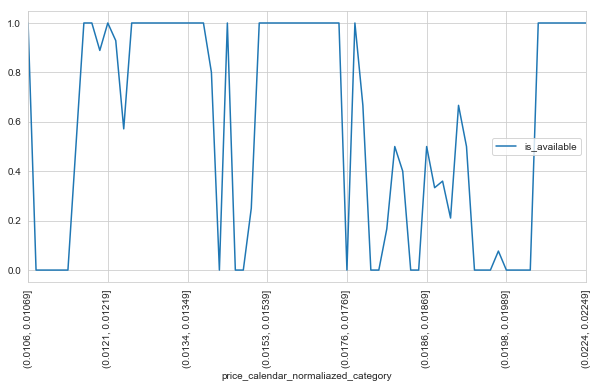

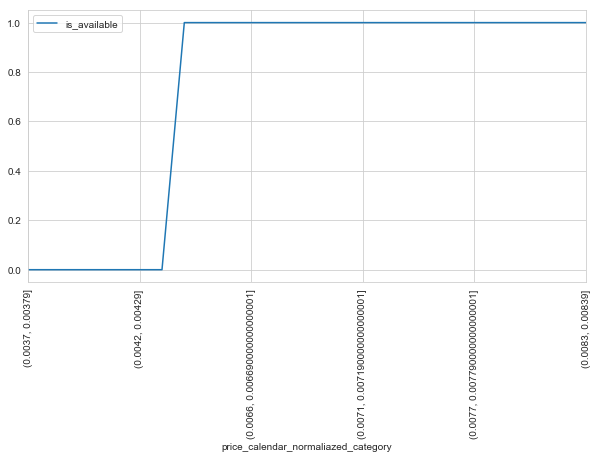

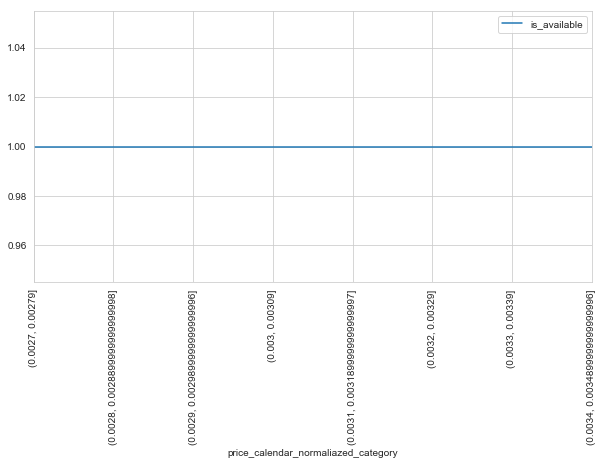

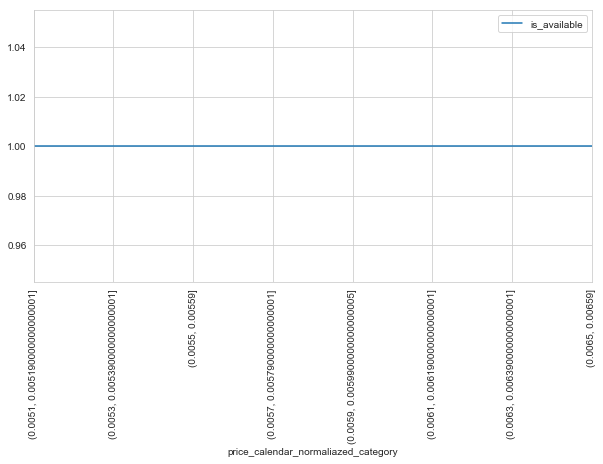

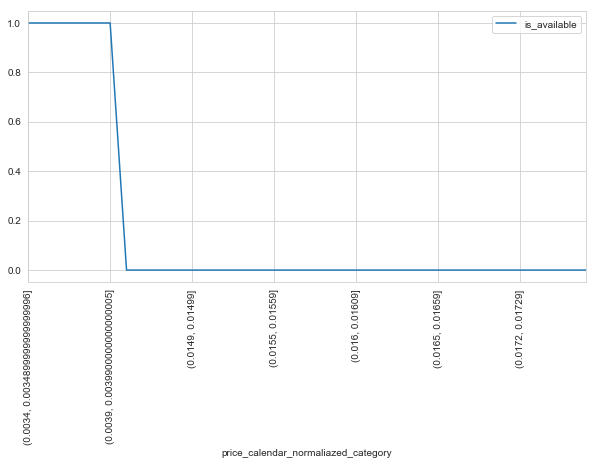

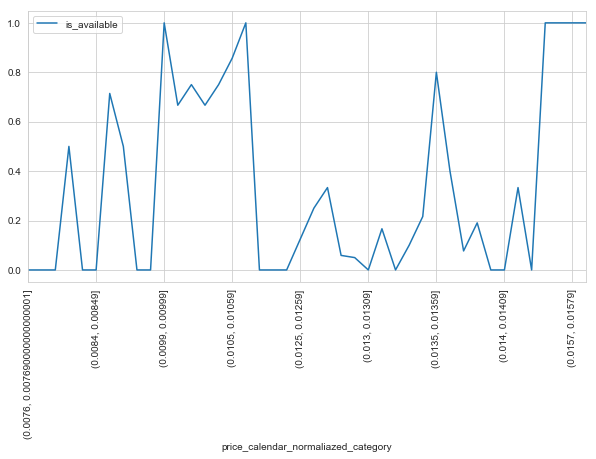

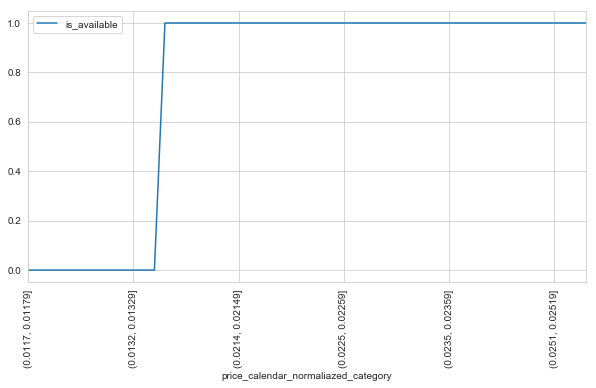

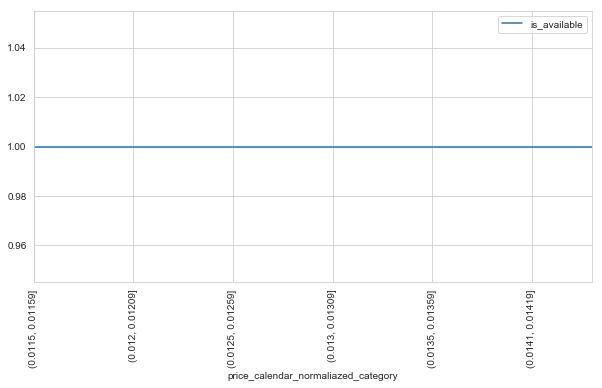

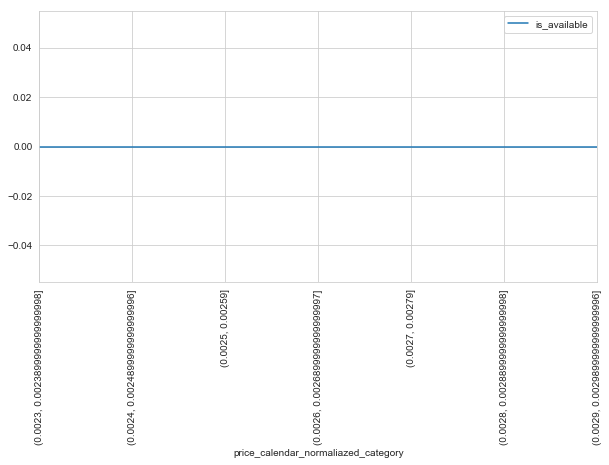

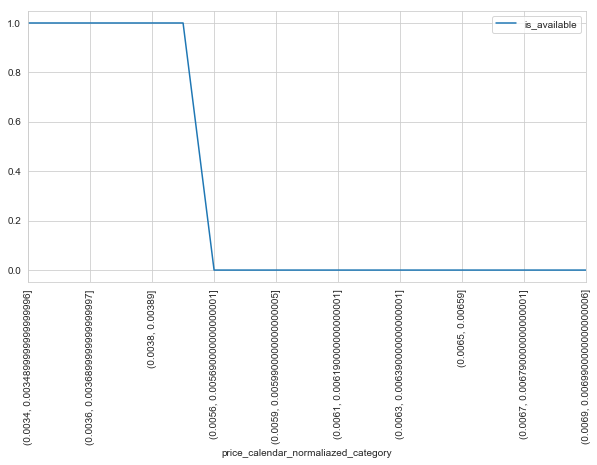

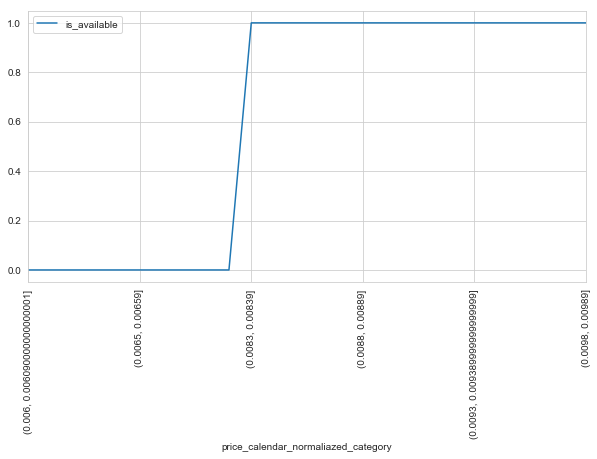

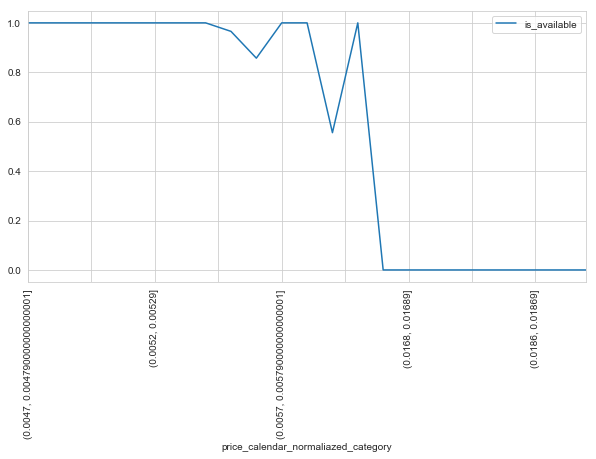

In [437]:
for listing_id in listing_ids:
    fig, ax = plt.subplots(figsize=(10,5))
    sns.set_style("whitegrid")
    temp_df = pd.DataFrame(sample_with_env.query("listing_id == @listing_id").groupby(by=["price_calendar_normaliazed_category"]).mean()["is_available"].dropna())
#     print(temp_df["is_available"])
    temp_df.plot(ax=ax).tick_params(axis='x', labelrotation=90)

### Ideas for improvement in accuracy of this predictive model
- I have not taken into consideration the hisorical booking rates and avaialbility of the property being evaluated for predicting its booking probability. However, that is very crucial information which can significantly improve the prediction quality of the alogrithm and can help tuning price better.
- Accuracy of predicting the probability of the property getting booked can be further improved by using all the training data availabile for training the Extreme Gradient Boosting model. Currently I have used only 100,000 samples execute my code within memory constraints imposed by Google Colab environment.
- Alternate models like deep neural network can also be utilized with availability of larger dataset and computing resources to train it and choosing the most optimal hyperparameters like number of hidden layers and number of neurons in each layer etc.

This kind of improvements can result in more accurate prediction about the expected revenue from property at given price point.

## Application of this price tuning model based on predictive analysis
Booking companies like **Booking.com**, **Trivago** and **OYO** can benefit from such kind of predictive price tuning model because they have more control over the booking price of the hotel room. Such a company can easily look at its past data of having each room offered at different prices and estimating the price elasticity for demand for each hotel room of some type. It can then train a predictive model for estimating the probability of a property getting booked at given price point on given day and market scenario. After calculating the price elasticity for given property, it can then tune the price of the hotel room type using above suggested method such that it maximizes expected revenue from that hotel room type on given day.